In [7]:
import mne, fooof, numpy as np, pandas as pd, os, glob, sys
from IPython.display import display, Markdown
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [8]:
projpath="/home/tmorshed/projects/def-johngrif/tmorshed/"

In [9]:
datapath=os.path.join(projpath, 'data', 'nmod')
gitpath=os.path.join(projpath, 'bme1500')
if os.path.exists(datapath) and os.path.exists(gitpath):
    display(Markdown("success"))
else:
    display(Markdown('fix it'))

success

In [10]:
os.chdir(datapath)

In [11]:
def md(input):
    display(Markdown(input))
    
## DATA LOARDERS:

def finder():
    filesDepth5 = glob.glob('*/*/*/*/*')
    dirsDepth5 = filter(lambda f: os.path.isdir(f), filesDepth5)

    markers=np.sort(np.array([os.path.join(datapath, f) for f in filesDepth5 if f.endswith('.pkl')]))
    npzs=np.sort(np.array([os.path.join(datapath, f) for f in filesDepth5 if f.endswith('.npz')]))
    return markers, npzs

def load_to_df(markers, npzs, sno):
    _marker=pd.read_pickle(markers[sno])
    fs=_marker['fs']
    dt=1/fs


    with open(npzs[sno], 'rb') as f:
        _npz=np.load(f)
        _data=_npz.f.arr_0
        f.close()
    _df_data=pd.DataFrame(_data,
                          index=_marker['chNames'])
    _df_data.columns=_df_data.columns*dt

    a=pd.DataFrame(np.zeros((np.shape(_data)[-1]), dtype=str))
    a.index=a.index*dt

    _dfidx = pd.DataFrame([i['type'] for i in _marker['mrk']], index=[i['idx']*dt for i in _marker['mrk']])
    _dfidx=_dfidx.drop(labels=_dfidx.index[0])

    for i in _dfidx.index:
        a.loc[i]=_dfidx.loc[i]

    intdict={"":0,
            "s":1,
            "x":2,
            "na":3}

    for x in intdict:
        a=a.replace(x, int(intdict[x]))
    a=a.T
    a.index=['stim']

    _df_data=pd.concat([_df_data, a])
    _df_data.columns.names=['t']
    _df_data.index.names=['ch']
    return _marker, _df_data

def df_to_mne(_marker, _df_data):
    info = mne.create_info(ch_names=list(_df_data.index), sfreq=_marker['fs'], ch_types=(['eeg']*64)+(['misc']*7)+['stim'])
    info['subject_info']={"id":_marker['patientId']}
    raw=mne.io.RawArray(_df_data,info)
    raw.set_montage('standard_1020')
    return raw

In [12]:
markers, npzs = finder()
_marker, _df_data=load_to_df(markers, npzs, 0)

In [13]:
marker_sids=pd.DataFrame([i.split("/")[-5] for i in markers], columns=['sid'])

In [14]:
npz_sids=pd.DataFrame([i.split("/")[-5] for i in npzs], columns=['sid'])

In [15]:
fs=marker_sids.join(pd.DataFrame(markers, columns=['csvs'])).join(pd.DataFrame(npzs, columns=['npzs']).join(pd.DataFrame([i.split("/")[-1].split('_')[1] for i in markers], columns=['sess']))).set_index(['sid', 'sess']).sort_index()

In [16]:
a = pd.DataFrame([int(fs.index[i][0]) for i in range(len(fs))], columns=['sids'])

In [17]:
len(np.unique(a))

16

In [18]:
b = pd.DataFrame([fs.index[i][1] for i in range(len(fs))], columns=['n_trials'])

In [19]:
c = a.join(b).set_index(['sids']).sort_index()

In [20]:
n_trials=[int(c.loc[i].max()[0]) for i in c.index.unique()]

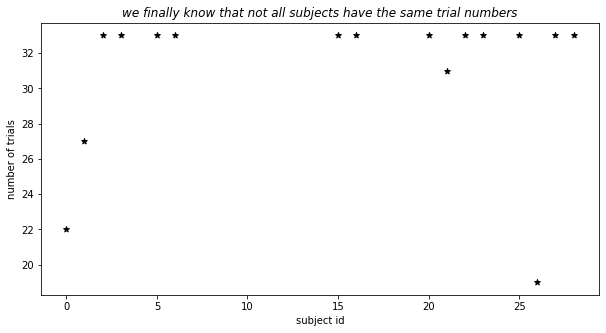

In [21]:
plt.figure(figsize=(10, 5))
plt.scatter(x=c.index.unique(), y=n_trials, c='k', marker='*')
plt.xlabel('subject id')
plt.ylabel('number of trials')
plt.yticks=np.sort(np.unique(n_trials))
plt.title('we finally know that not all subjects have the same trial numbers', fontstyle='oblique')
plt.show()

In [25]:
ls $datapath -l | wc -l

18


### Plotting stimulations:

In [36]:
d=np.unique(np.array(_df_data.iloc[-1,:]))

,0,1,2,3
0,,s,x,na


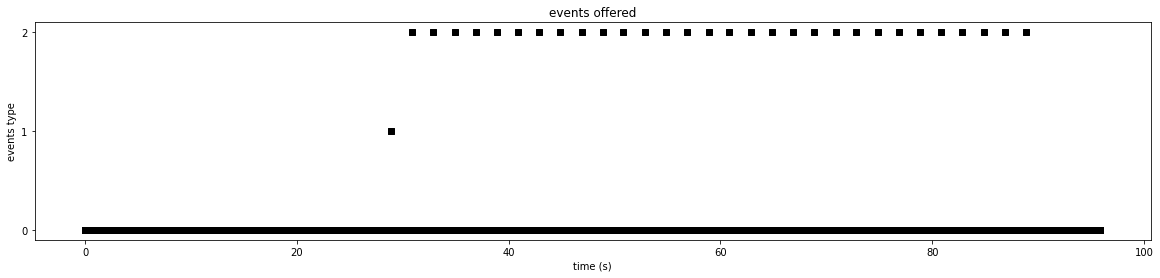

In [37]:
fig,ax=plt.subplots(figsize=(20,4))
plt.scatter(x=load_to_df(markers,npzs, 15)[1].columns,y=b, color="k", marker="s")
plt.xlabel('time (s)')
plt.title('events offered')
ax.set_yticks(d)
plt.ylabel('events type')
display(pd.DataFrame(["", "s", "x", "na"]).T)
plt.show()

In [ ]:
_marker.keys()

In [38]:
_df_data.head()

t,0.0000,0.0002,0.0004,0.0006,0.0008,0.0010,0.0012,0.0014,0.0016,0.0018,...,95.8380,95.8382,95.8384,95.8386,95.8388,95.8390,95.8392,95.8394,95.8396,95.8398
ch,,,,,,,,,,,,,,,,,,,,,
Fp1,0.000187,0.000187,0.000186,0.000184,0.000183,0.000183,0.000183,0.000183,0.000182,0.000183,...,0.000014,0.000012,0.000010,0.000011,0.000011,0.000011,0.000011,0.000018,0.000045,0.000053
Fp2,-0.000053,-0.000050,-0.000050,-0.000051,-0.000051,-0.000052,-0.000052,-0.000051,-0.000051,-0.000052,...,-0.000023,-0.000025,-0.000026,-0.000025,-0.000025,-0.000026,-0.000026,-0.000015,0.000025,0.000033
F7,-0.000001,-0.000002,-0.000003,-0.000004,-0.000004,-0.000005,-0.000006,-0.000006,-0.000005,-0.000004,...,0.000005,0.000004,0.000005,0.000006,0.000005,0.000003,0.000002,0.000021,0.000088,0.000086
F3,0.000018,0.000018,0.000015,0.000014,0.000014,0.000015,0.000014,0.000014,0.000015,0.000016,...,0.000021,0.000019,0.000019,0.000019,0.000020,0.000021,0.000022,0.000024,0.000033,0.000036
Fz,-0.000053,-0.000054,-0.000057,-0.000061,-0.000061,-0.000060,-0.000060,-0.000060,-0.000060,-0.000059,...,-0.000018,-0.000020,-0.000019,-0.000018,-0.000017,-0.000017,-0.000016,-0.000005,0.000031,0.000017


In [39]:
raw = df_to_mne(_marker, _df_data)
fs=float(raw.info['sfreq'])
dt=1/fs
raw

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.


<RawArray | 72 x 479200 (95.8 s), ~263.3 MB, data loaded>

In [ ]:
raw.ch_names

31 events found
Event IDs: [1 2]


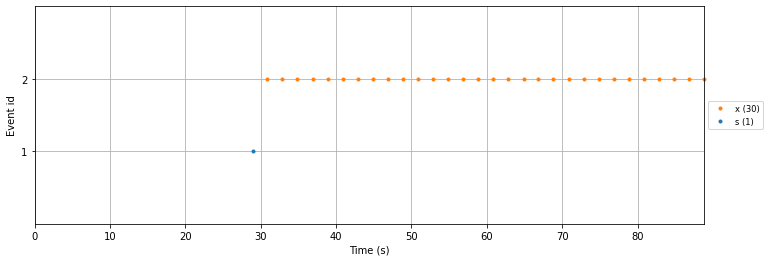

just making sure that the events register w. MNE


In [40]:
intdict=dict(s=1, x=2)
events=mne.find_events(raw)
fig,ax=plt.subplots(figsize=(15,4))
mne.viz.plot_events(events, sfreq=fs,first_samp=raw.first_samp, event_id=intdict, axes=ax)
print('just making sure that the events register w. MNE')

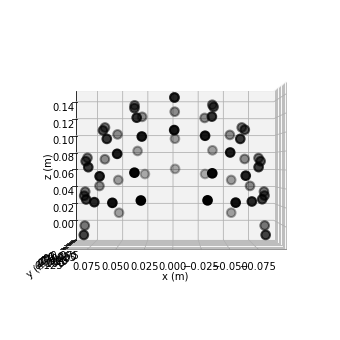

In [41]:
raw.plot_sensors('3d', block=True); 

In [37]:
epochs=mne.Epochs(raw, events=events)

Not setting metadata
31 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Seems like stim is happening towards the end:

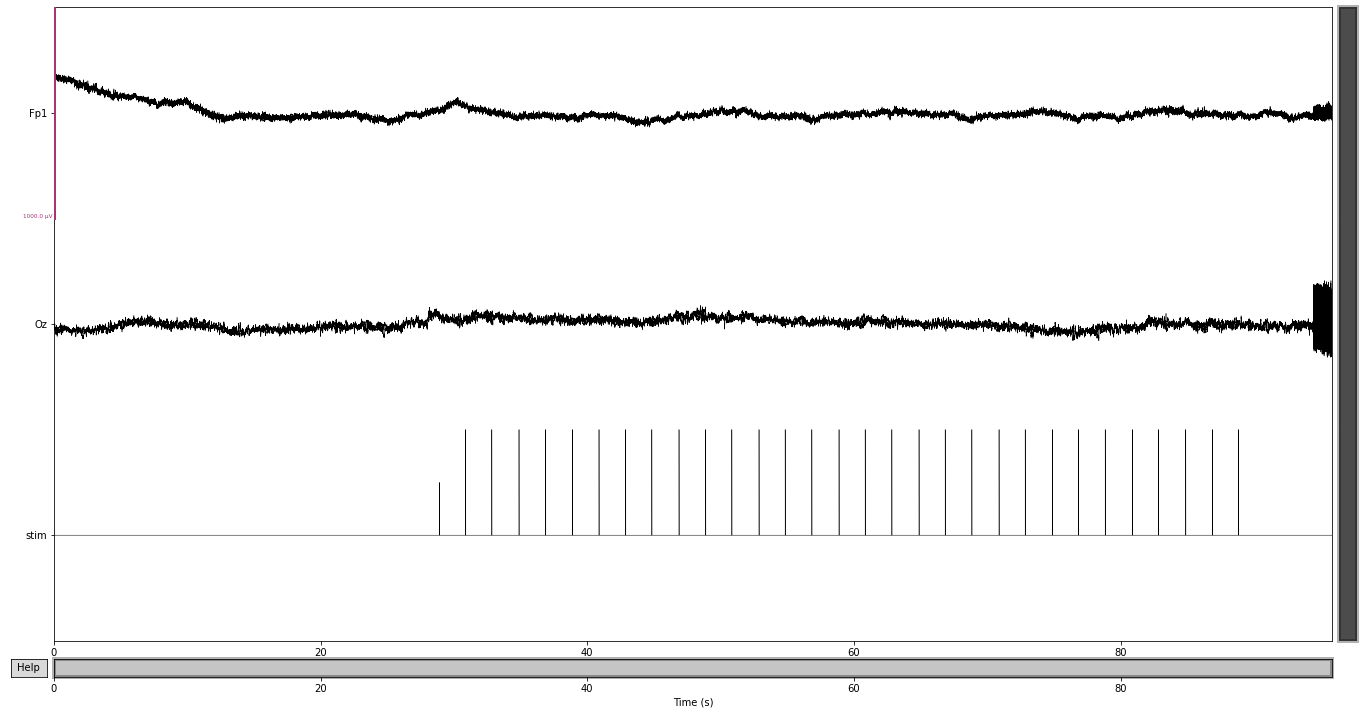

In [82]:
raw.copy().pick_channels(['Fp1', 'Oz', 'stim']).plot(scalings=50e-5, duration=raw.times[-1],event_color='cyan');

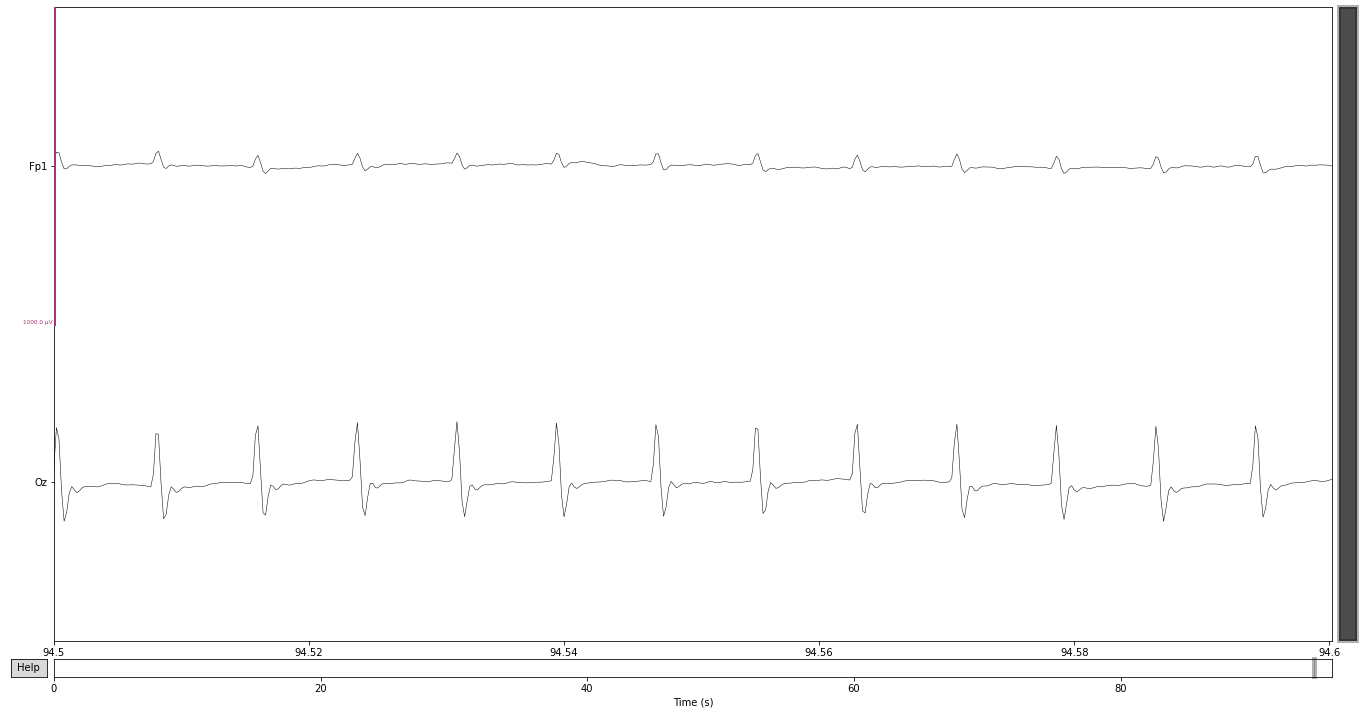

In [95]:
raw.copy().pick_channels(['Fp1', 'Oz']).plot(scalings=50e-5, start=94.5, duration=0.10 ,event_color='cyan');

Let's zoom in:

In [ ]:
raw.copy().pick_channels(['Fp1', 'Oz', 'stim']).plot(scalings=50e-5, duration=raw.times[-1],event_color='cyan');

In [101]:
ls /home/tmorshed/projects/def-johngrif/tmorshed/data/nmod/*/*/*/*

/home/tmorshed/projects/def-johngrif/tmorshed/data/nmod/0/raw/D1/left_r:
run_00_data.npy.npz  run_08_data.npy.npz  run_16_data.npy.npz
run_00_hdr.pkl       run_08_hdr.pkl       run_16_hdr.pkl
run_01_data.npy.npz  run_09_data.npy.npz  run_17_data.npy.npz
run_01_hdr.pkl       run_09_hdr.pkl       run_17_hdr.pkl
run_02_data.npy.npz  run_10_data.npy.npz  run_18_data.npy.npz
run_02_hdr.pkl       run_10_hdr.pkl       run_18_hdr.pkl
run_03_data.npy.npz  run_11_data.npy.npz  run_19_data.npy.npz
run_03_hdr.pkl       run_11_hdr.pkl       run_19_hdr.pkl
run_04_data.npy.npz  run_12_data.npy.npz  run_20_data.npy.npz
run_04_hdr.pkl       run_12_hdr.pkl       run_20_hdr.pkl
run_05_data.npy.npz  run_13_data.npy.npz  run_21_data.npy.npz
run_05_hdr.pkl       run_13_hdr.pkl       run_21_hdr.pkl
run_06_data.npy.npz  run_14_data.npy.npz  run_22_data.npy.npz
run_06_hdr.pkl       run_14_hdr.pkl       run_22_hdr.pkl
run_07_data.npy.npz  run_15_data.npy.npz
run_07_hdr.pkl       run_15_hdr.pkl

/home/tmorshed/p

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
0 :


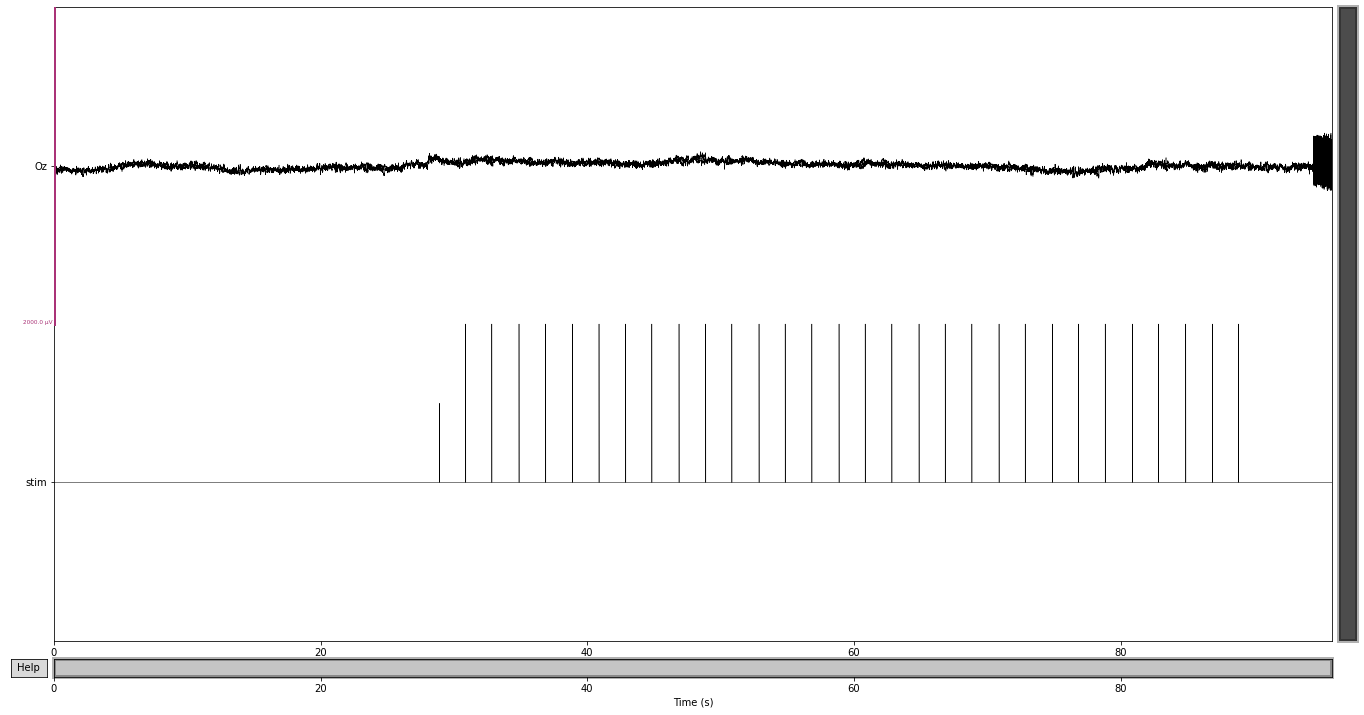

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
1 :


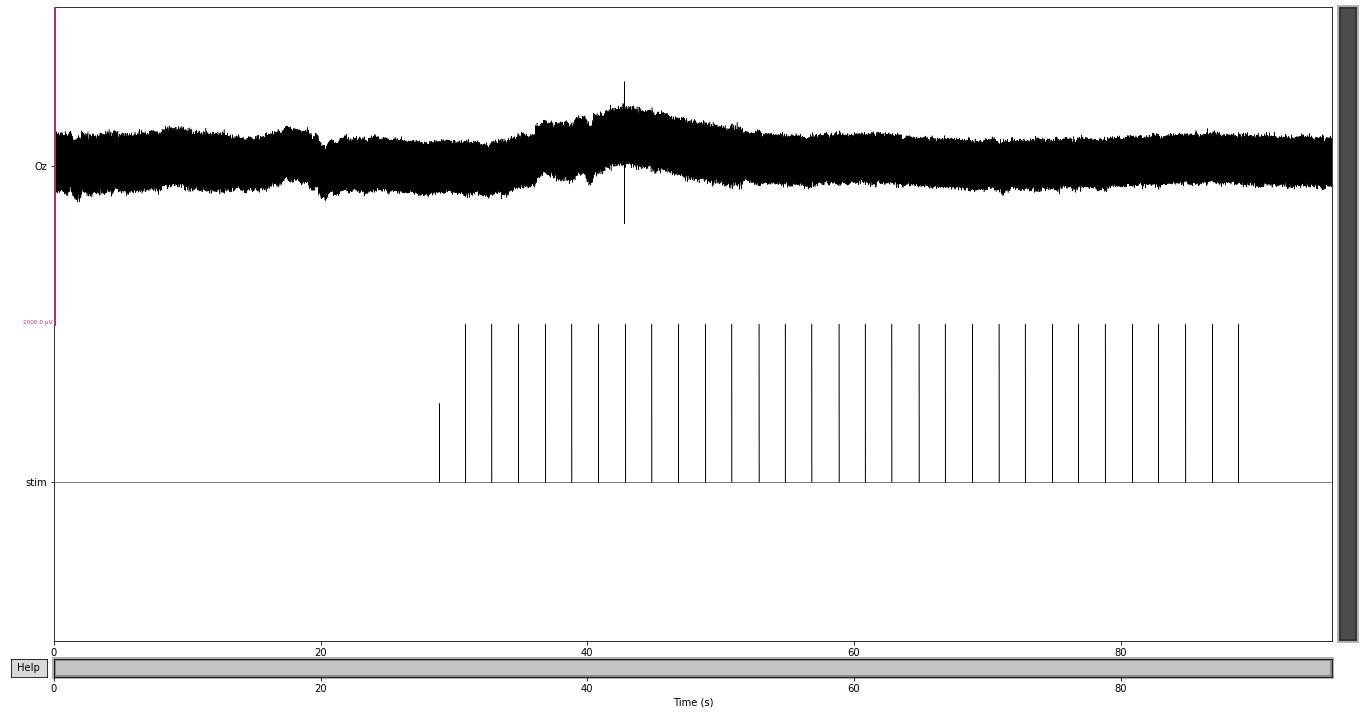

Creating RawArray with float64 data, n_channels=72, n_times=479400
    Range : 0 ... 479399 =      0.000 ...    95.880 secs
Ready.
2 :


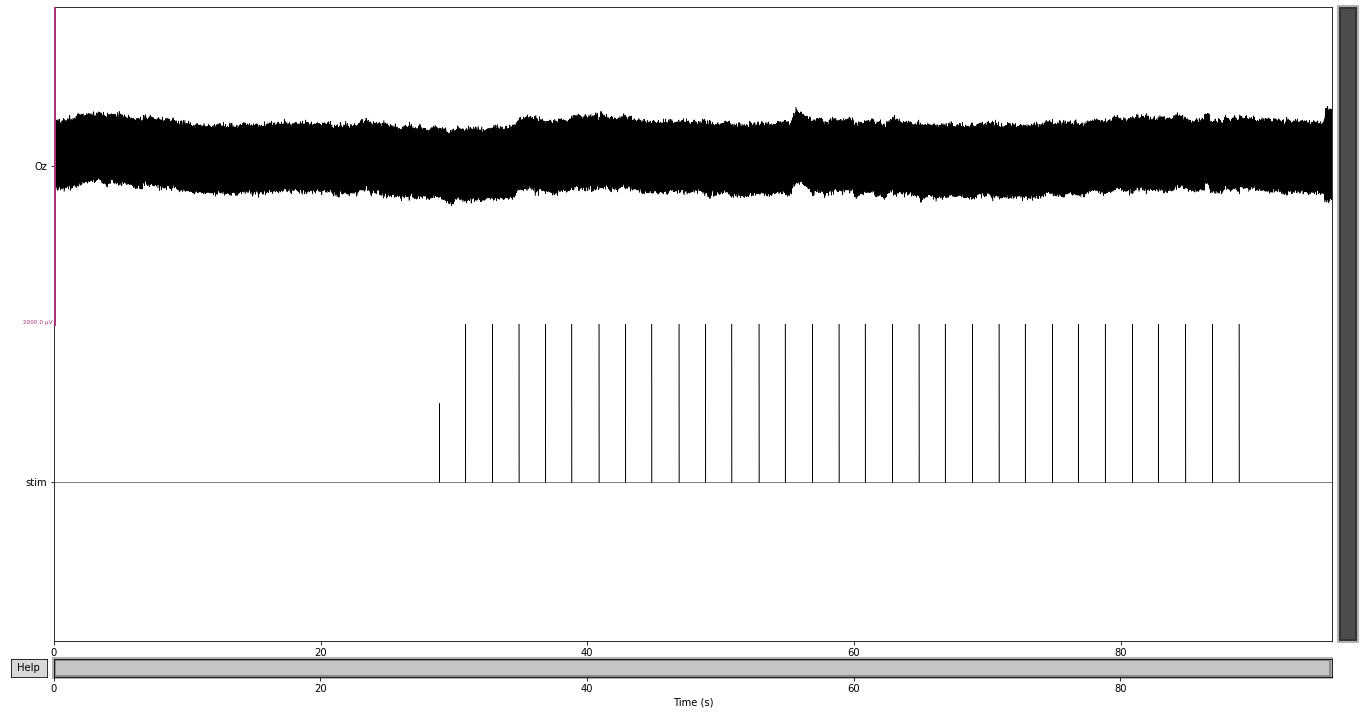

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
3 :


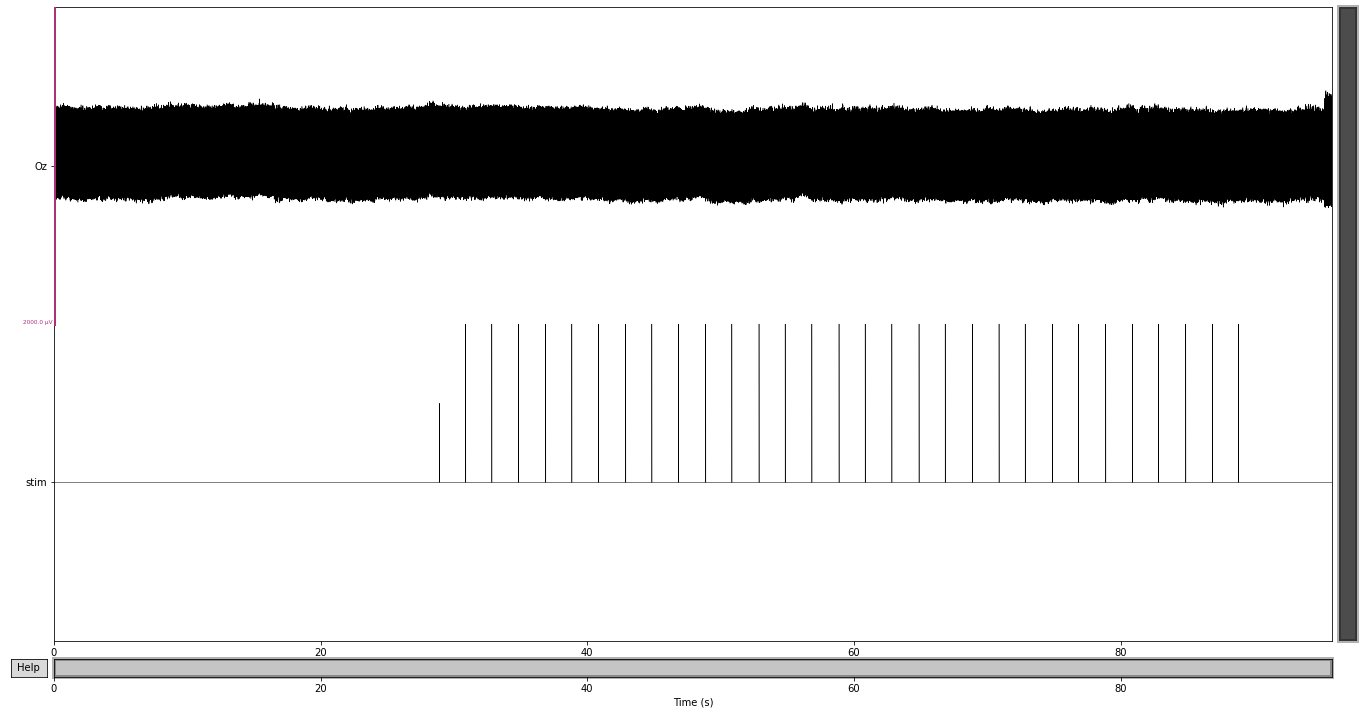

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
4 :


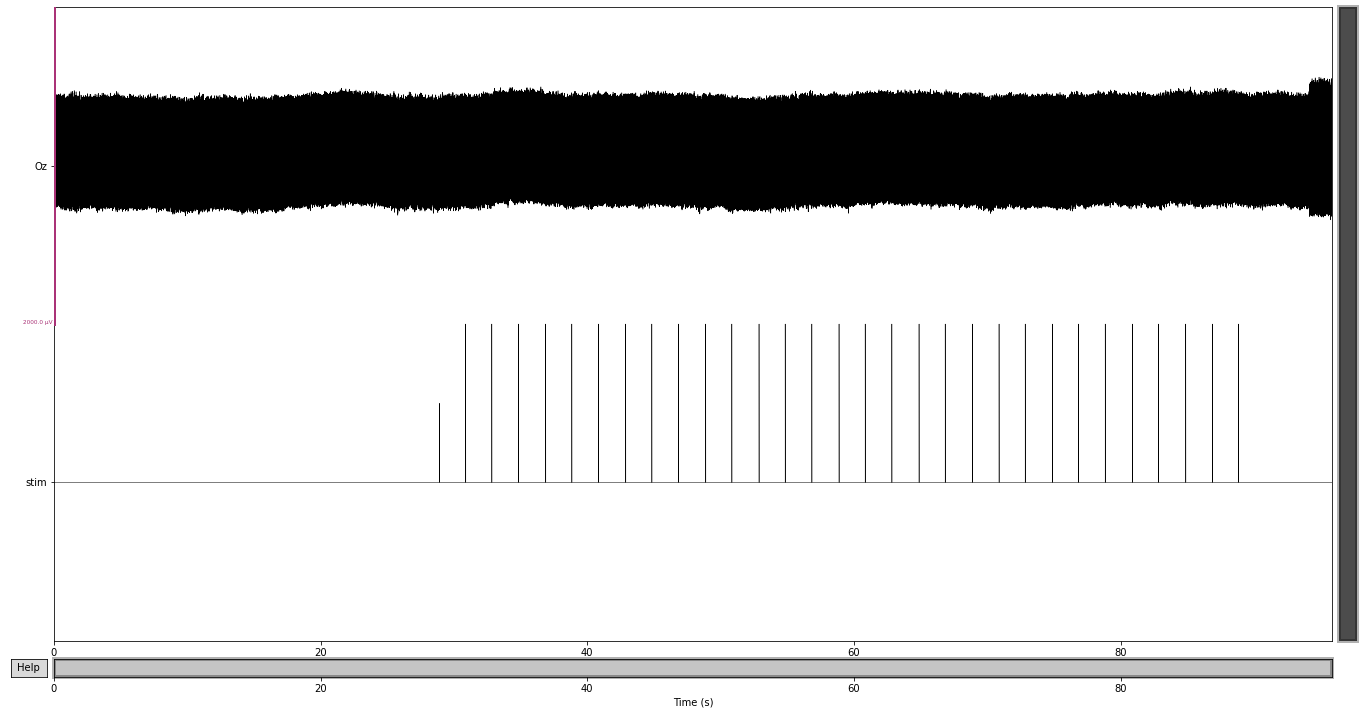

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
5 :


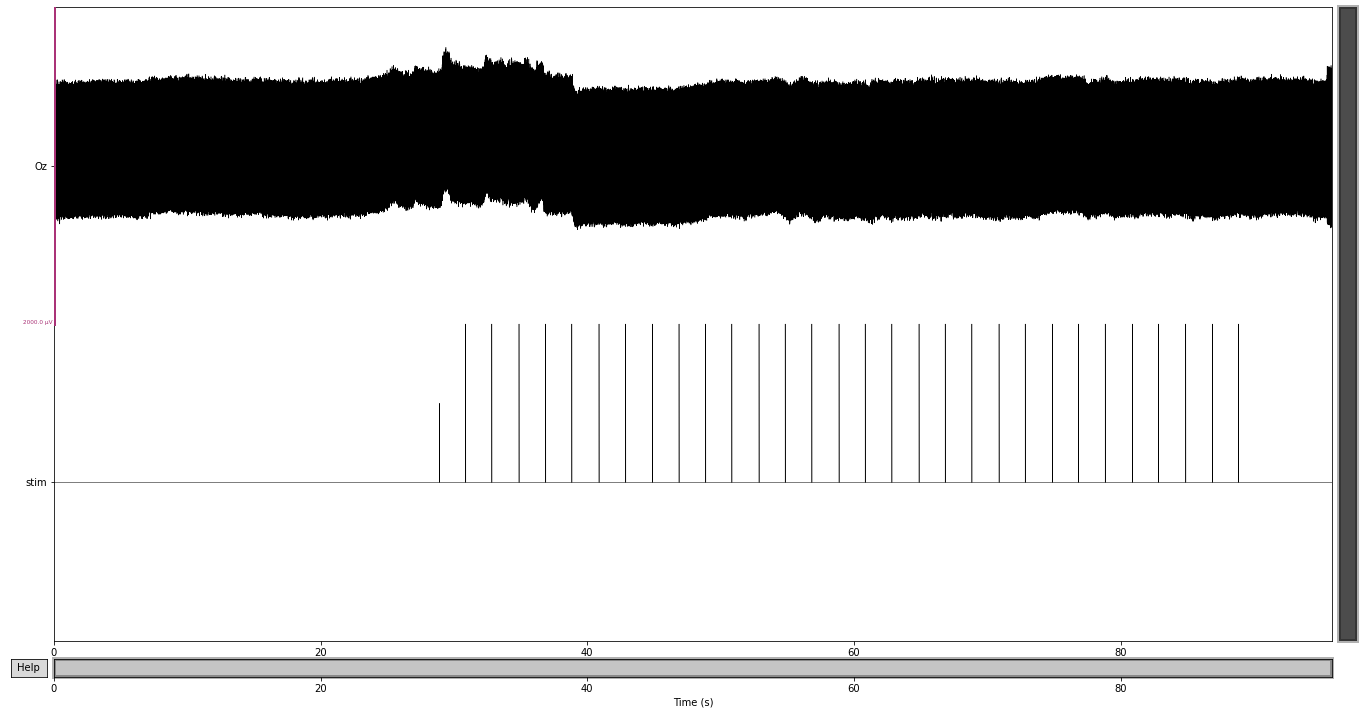

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
6 :


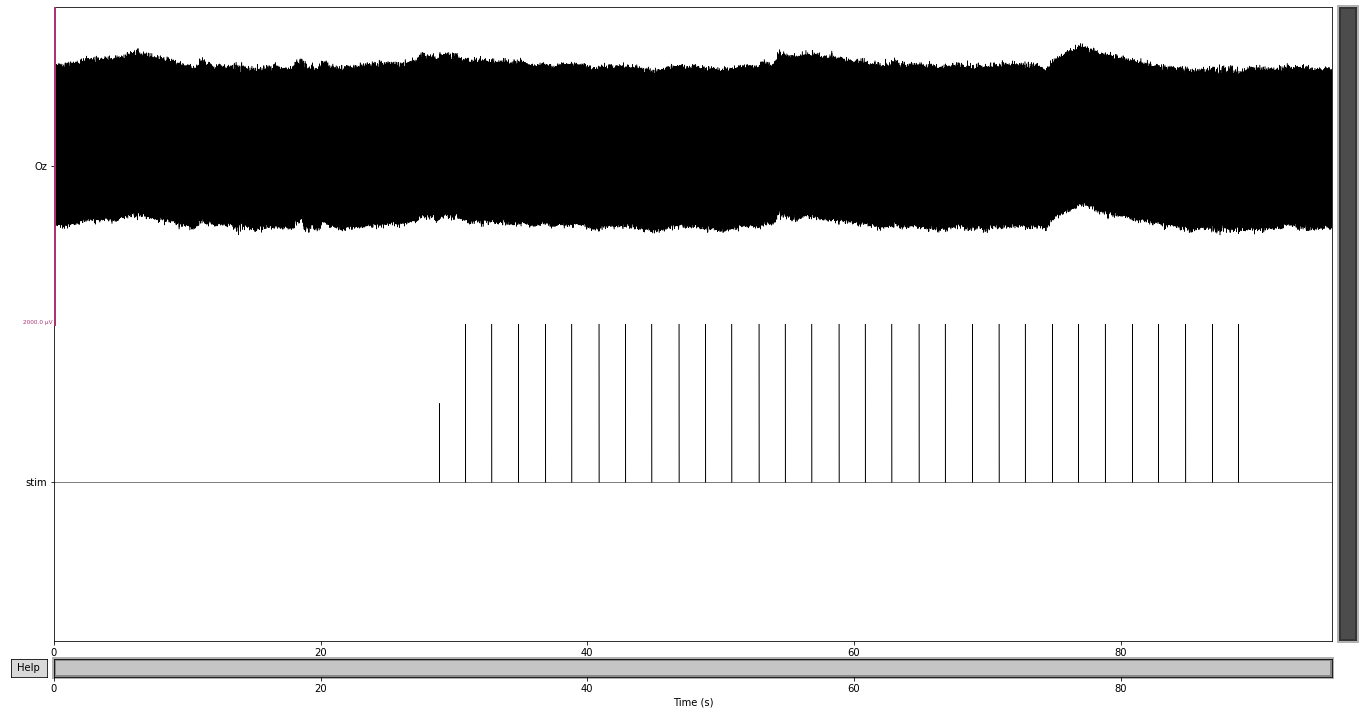

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
7 :


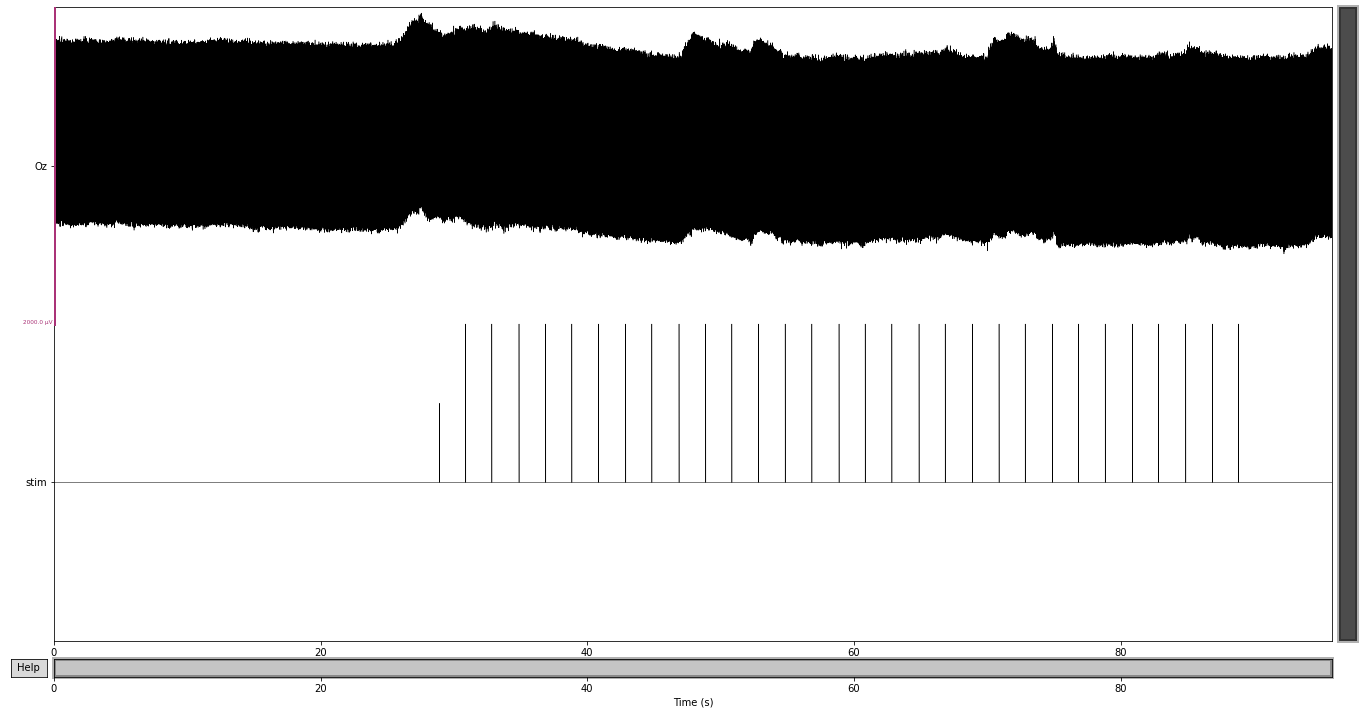

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
8 :


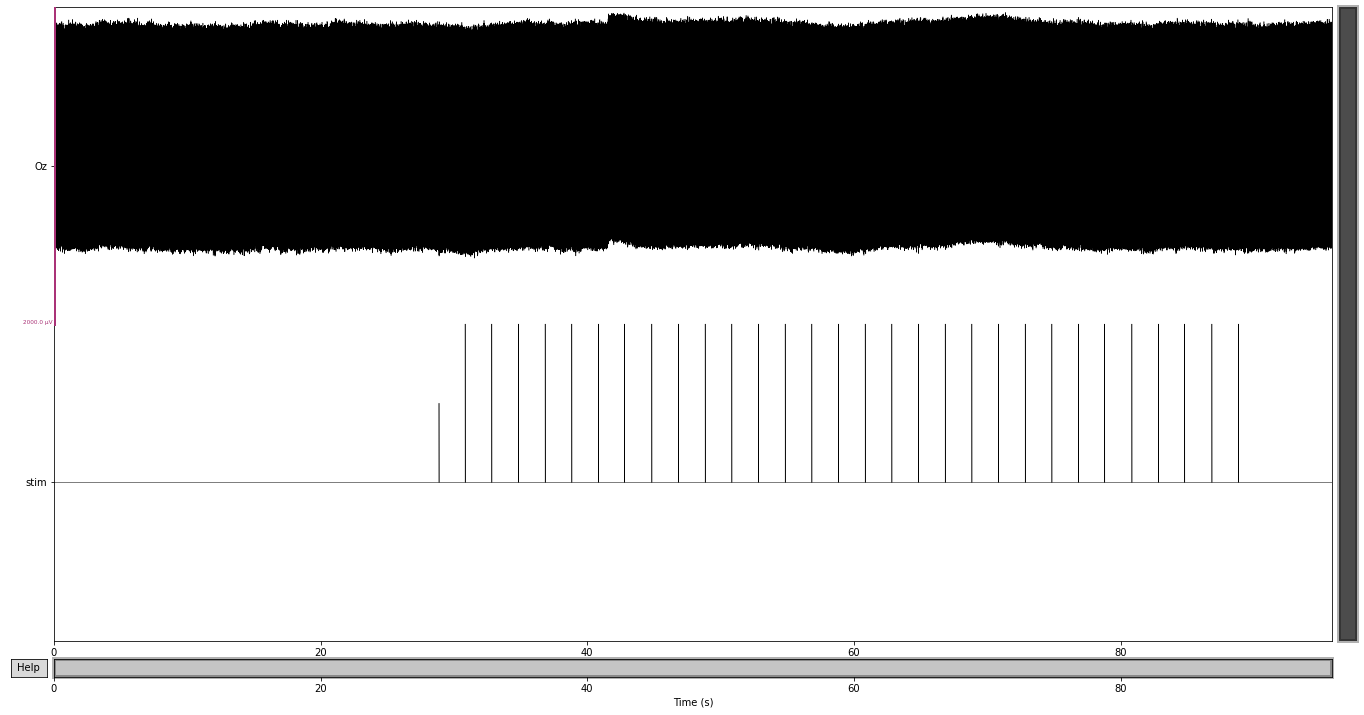

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
9 :


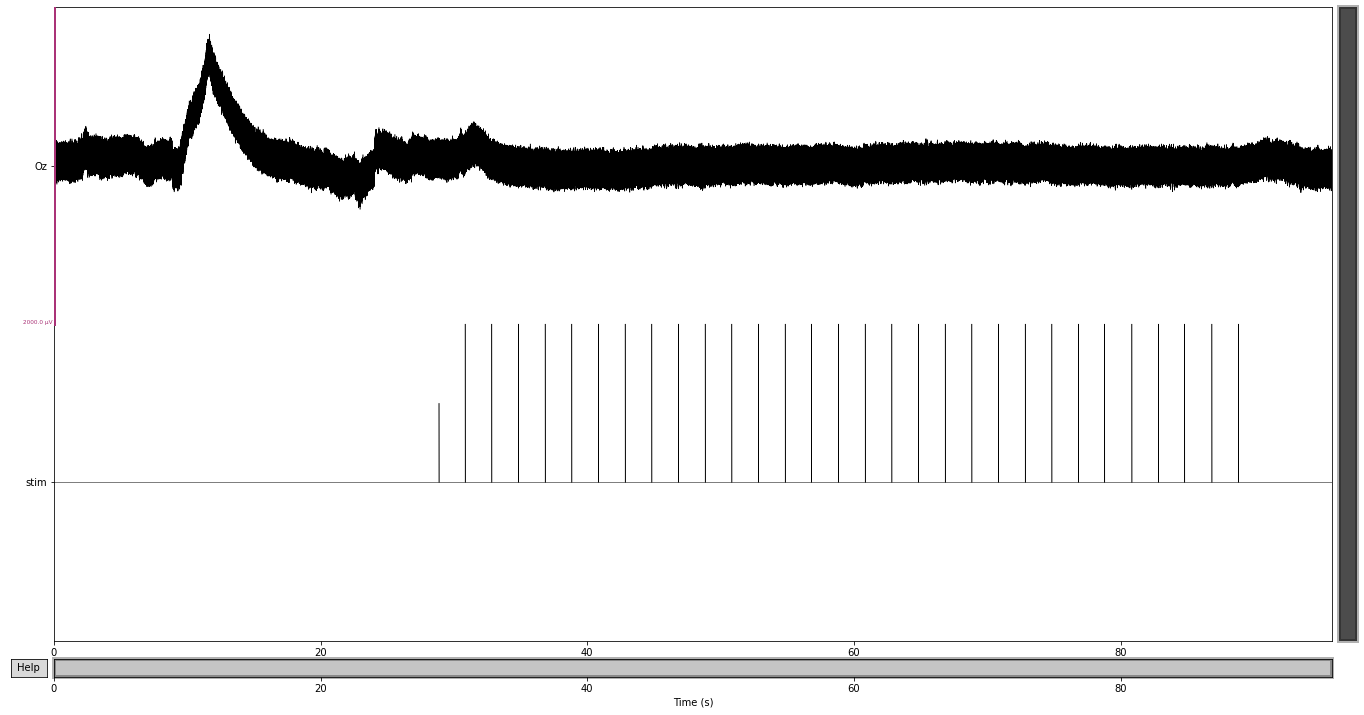

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
10 :


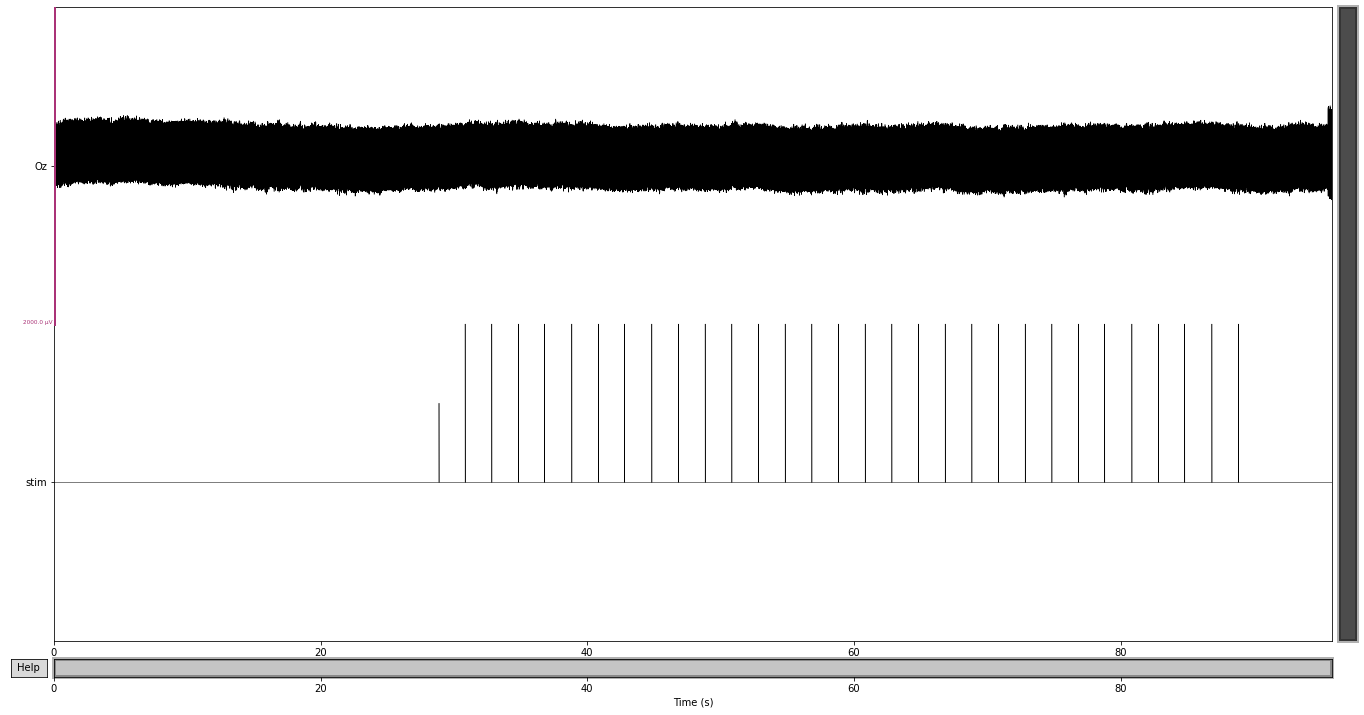

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
11 :


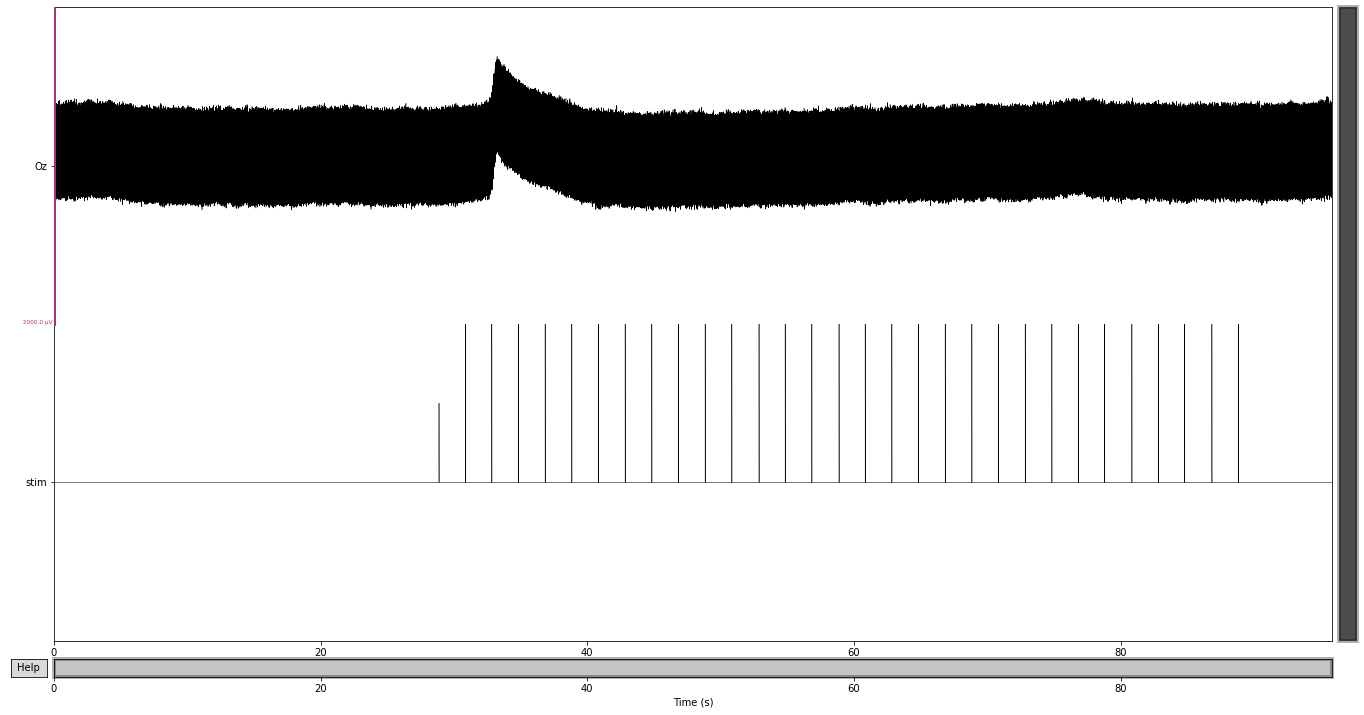

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
12 :


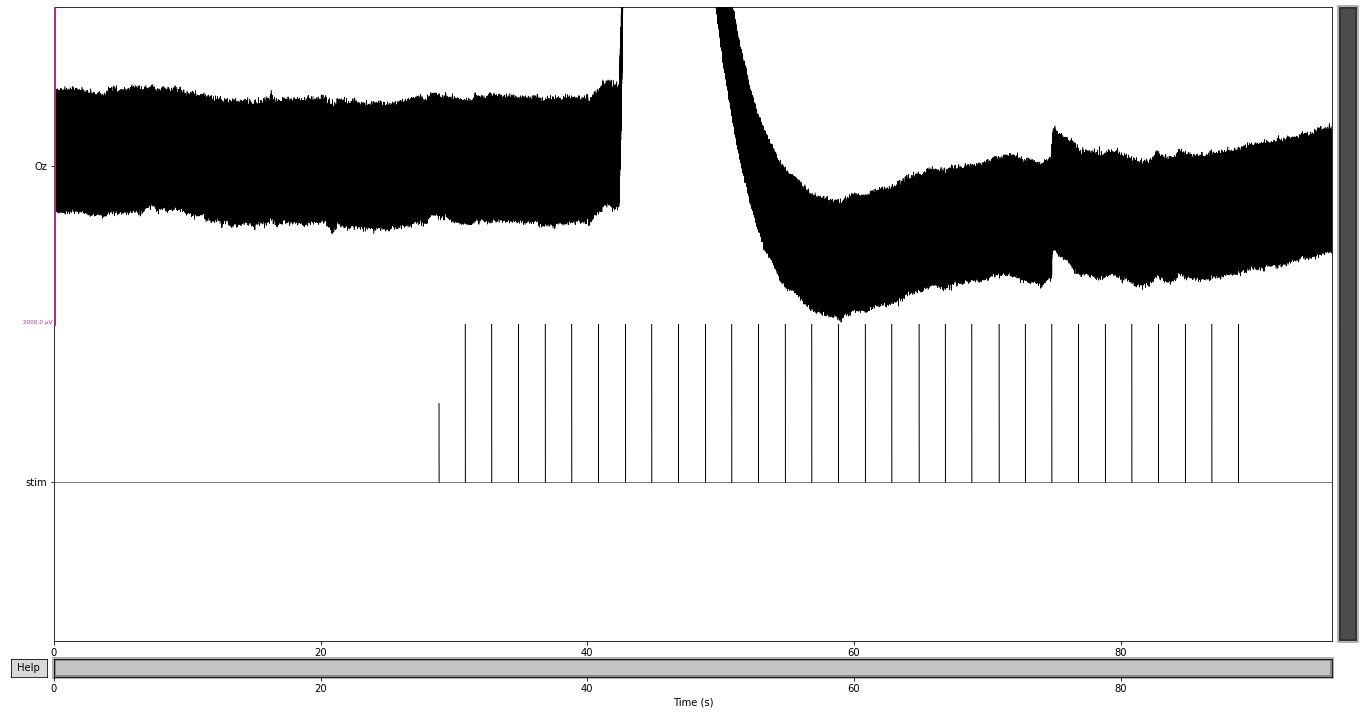

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
13 :


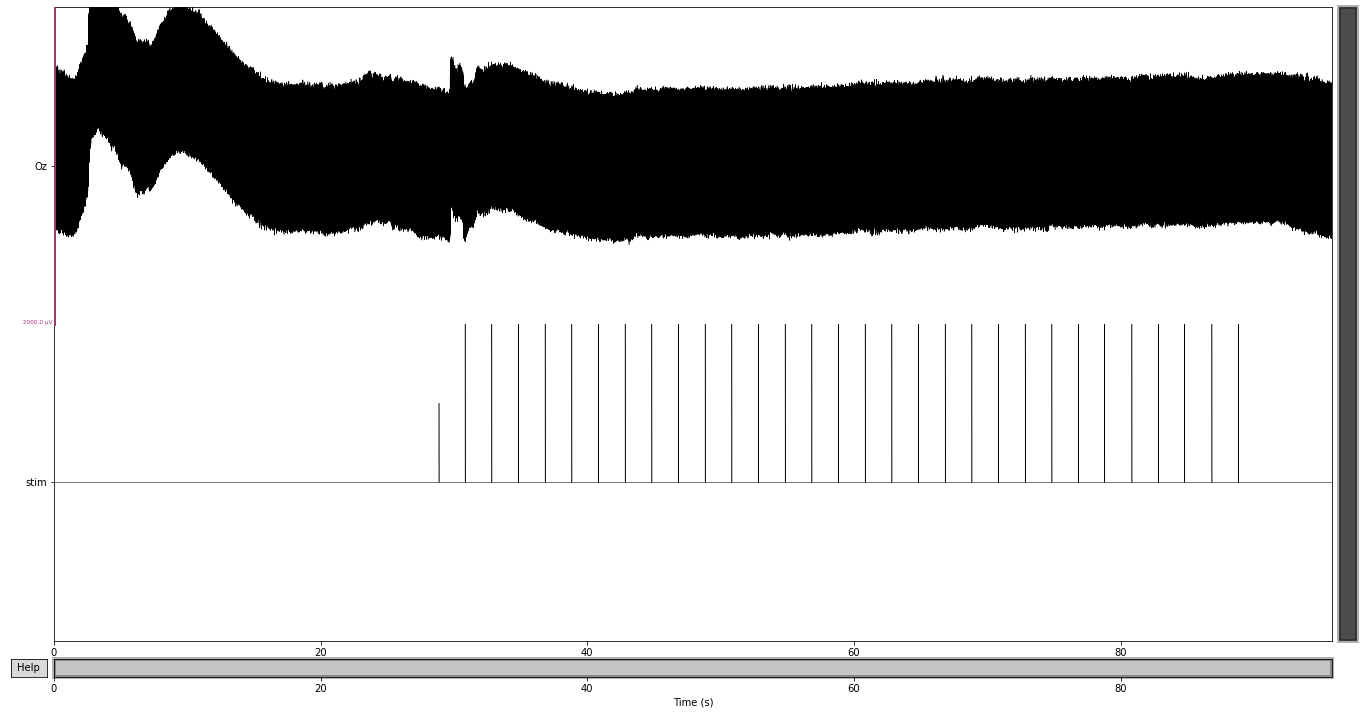

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
14 :


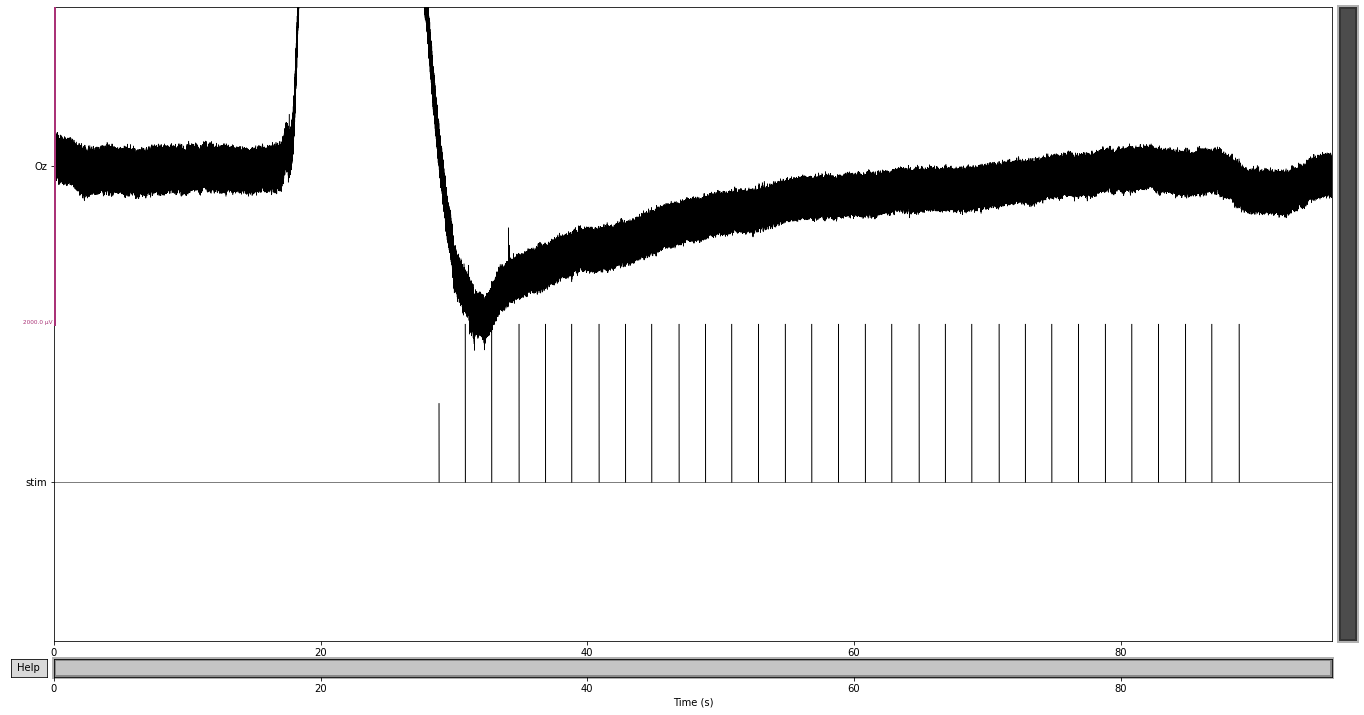

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
15 :


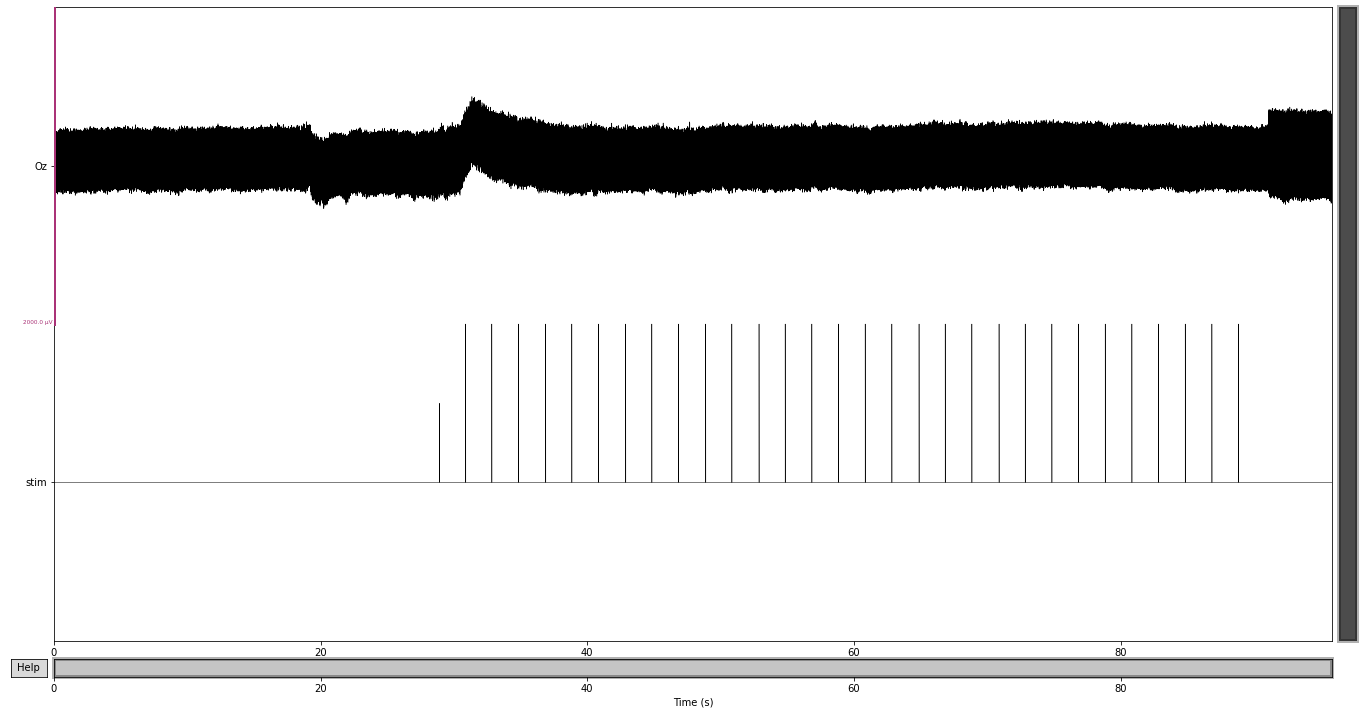

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
16 :


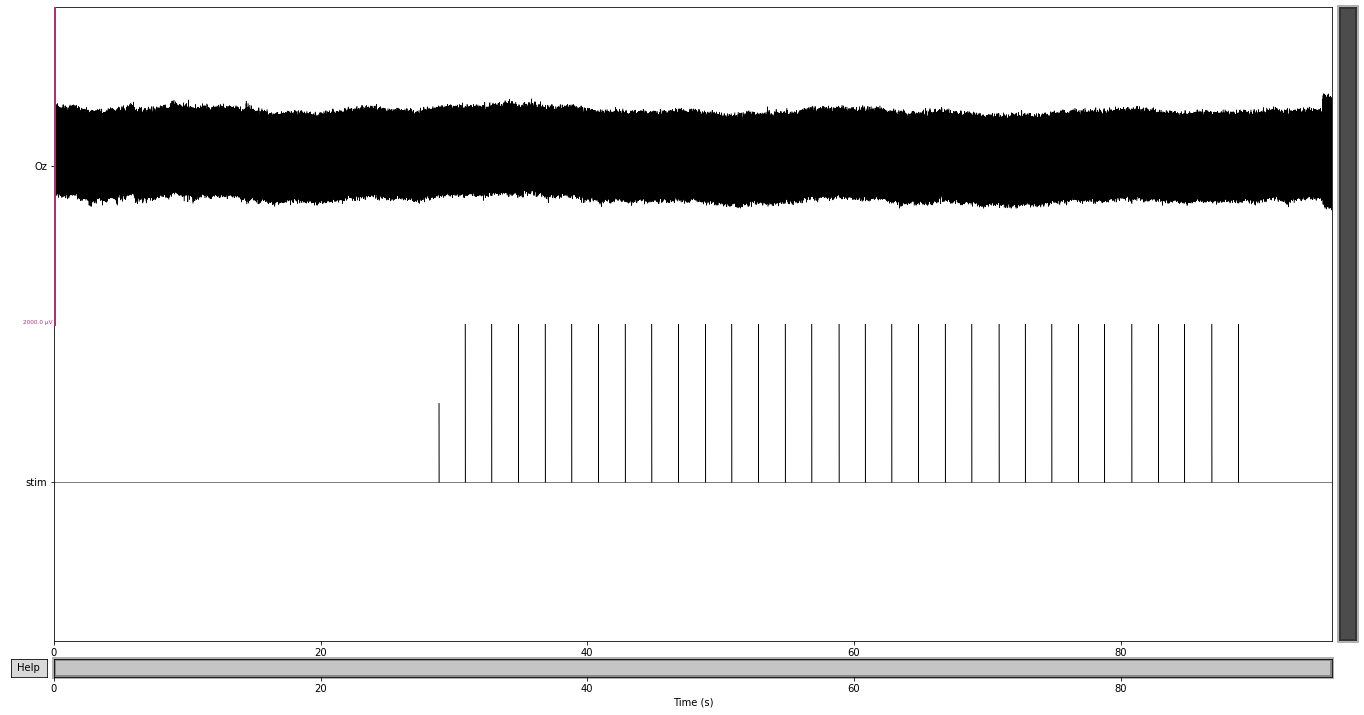

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
17 :


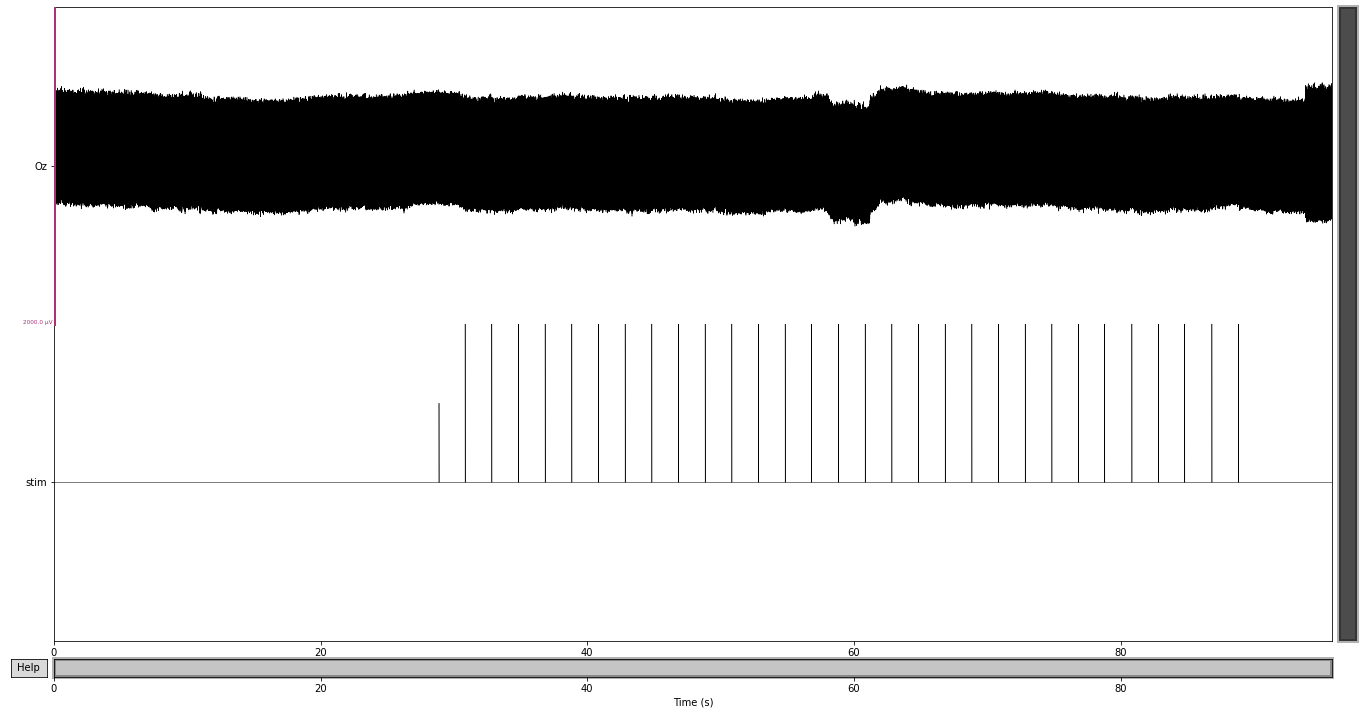

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
18 :


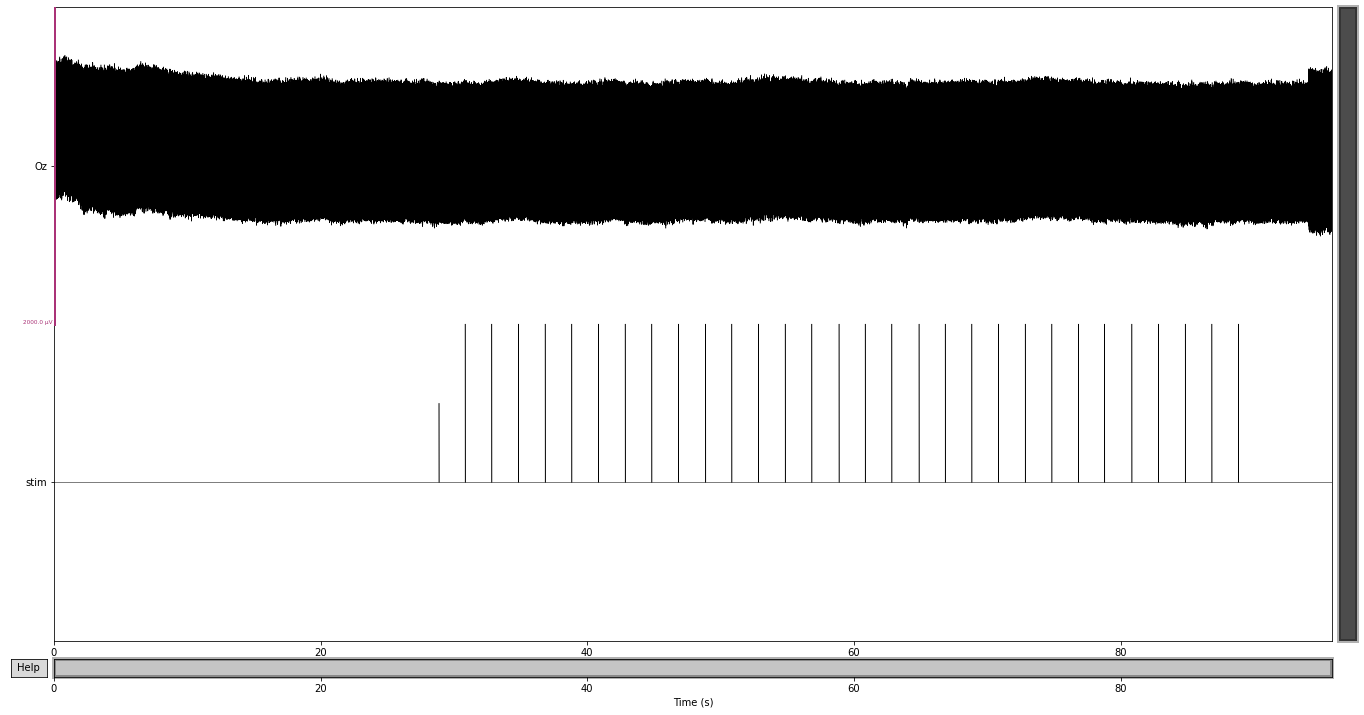

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
19 :


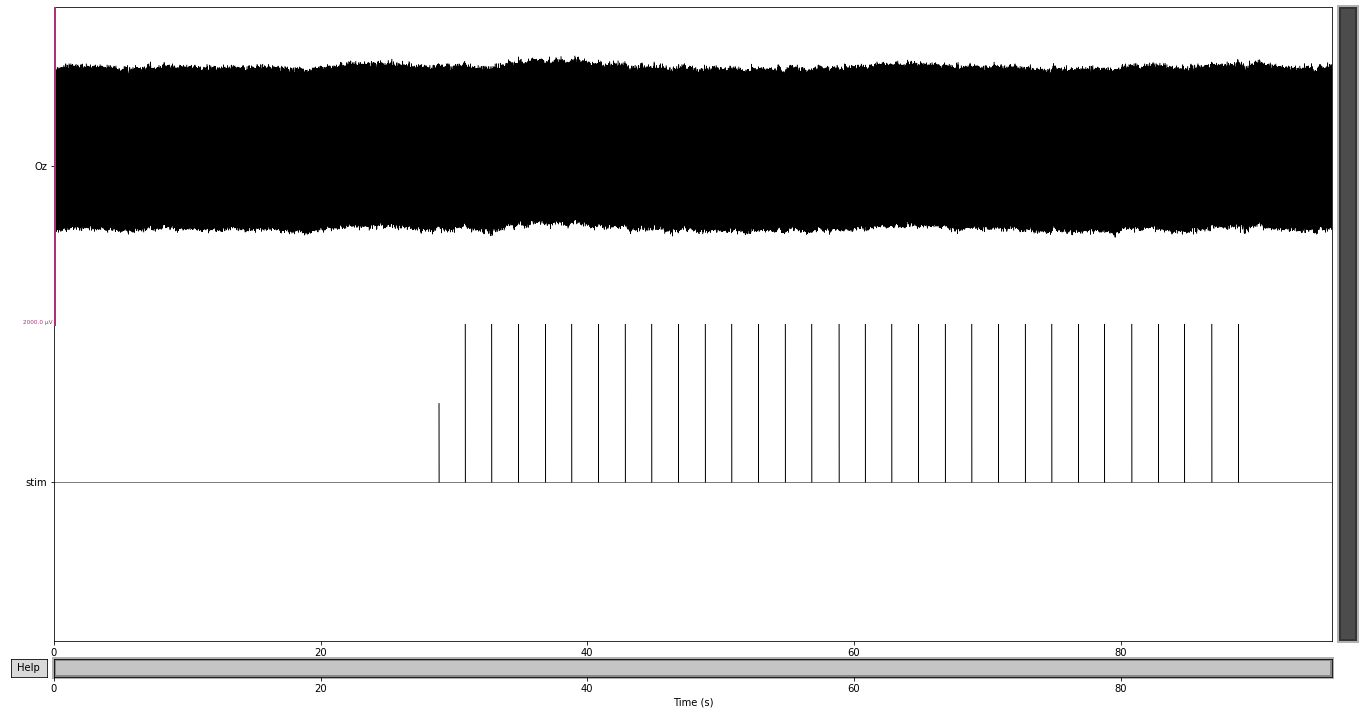

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
20 :


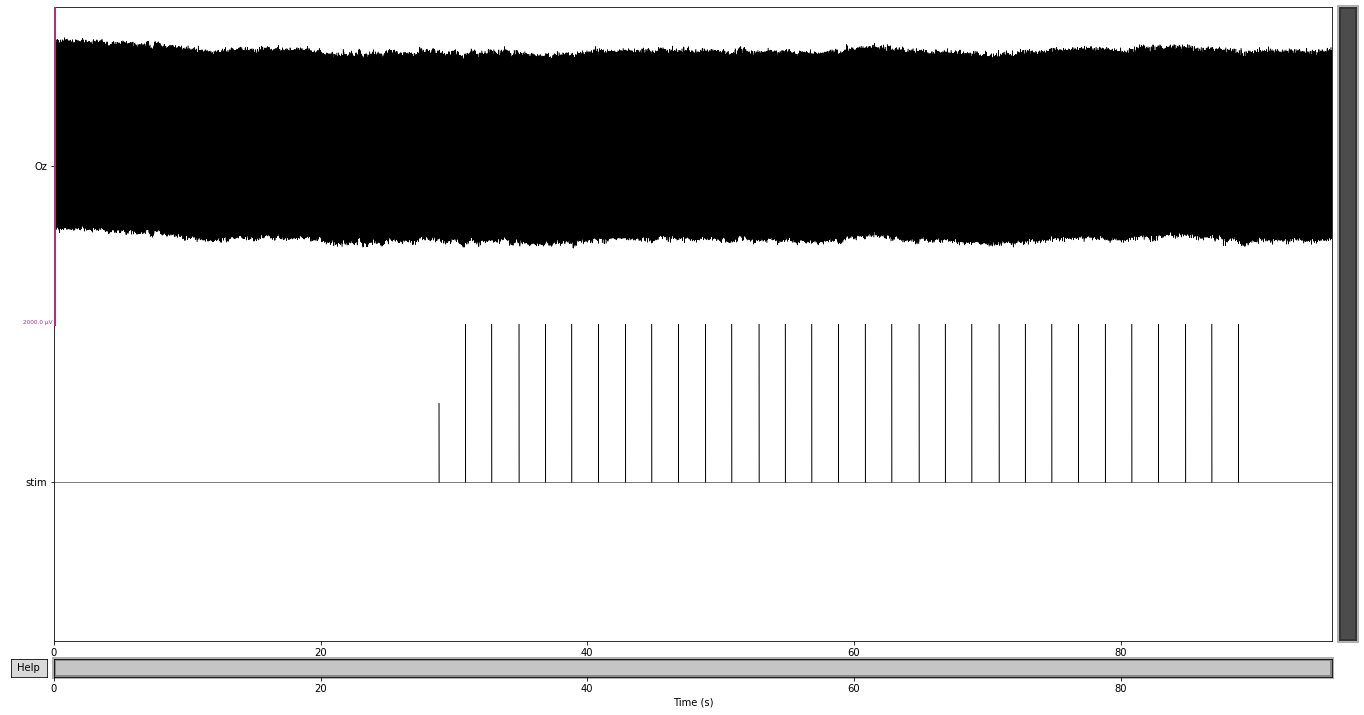

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
21 :


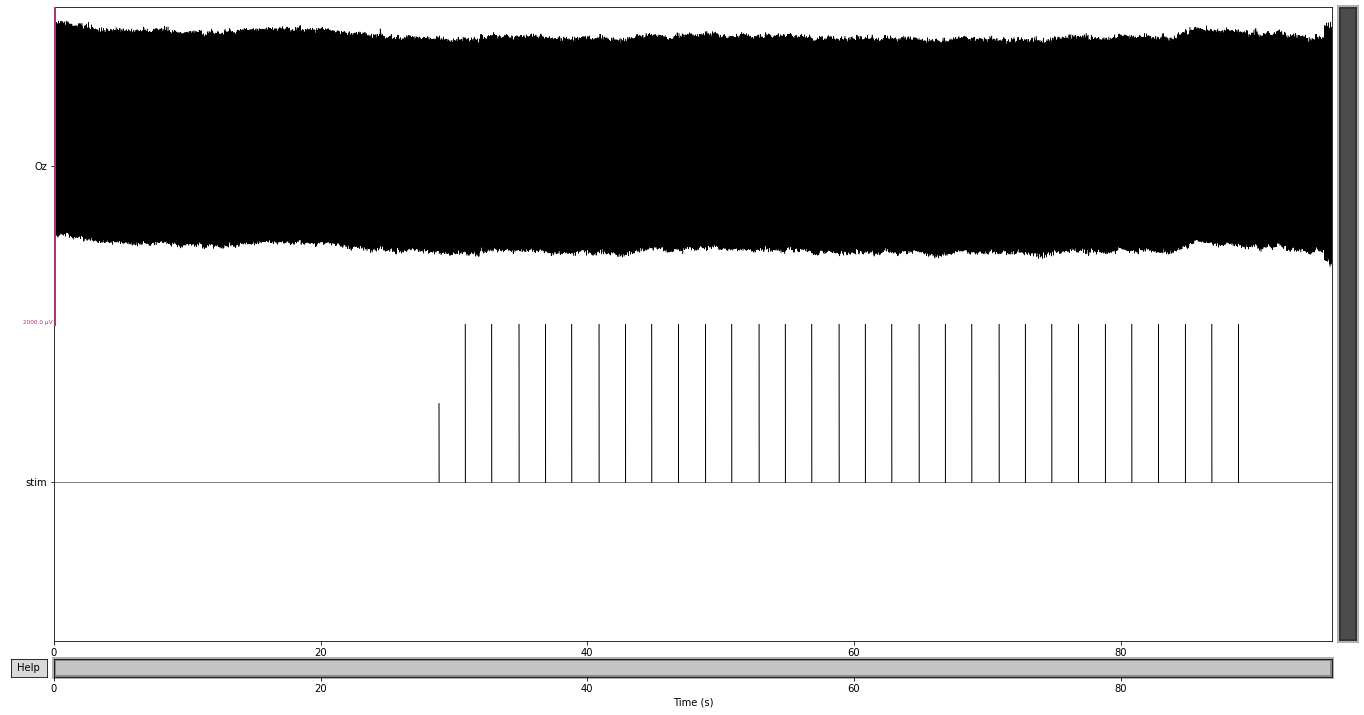

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
22 :


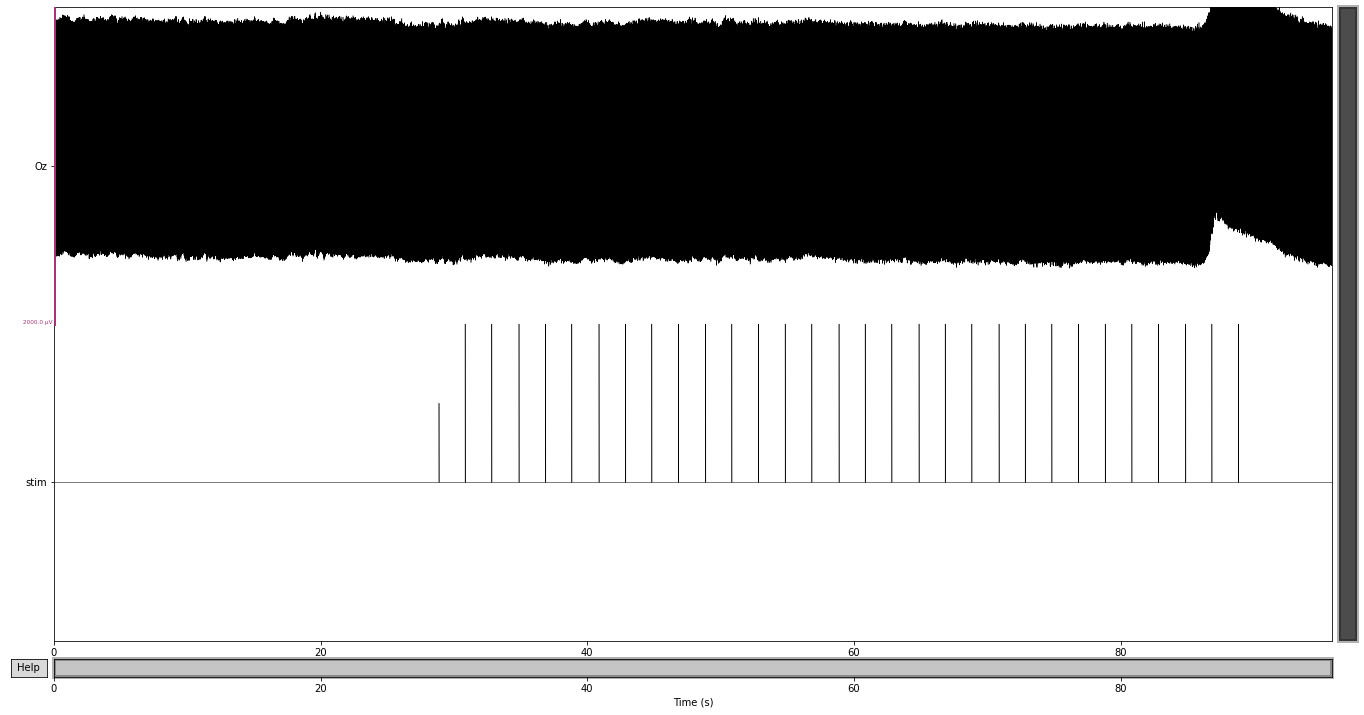

In [153]:
for i in range(23):
    _marker, _df_data=load_to_df(markers, npzs, i)
    _raw=df_to_mne(_marker, _df_data)
    print(i, ":")
    _raw.copy().pick_channels(['stim', 'Oz']).plot(start=0, duration=raw.times[-1], n_channels=2, scalings=1e-3);

In [144]:
_marker

{'fs': 5000.0,
 'patientId': 1,
 'clinScore': 1,
 'chNames': ['Fp1',
  'Fp2',
  'F7',
  'F3',
  'Fz',
  'F4',
  'F8',
  'FC5',
  'FC1',
  'FC2',
  'FC6',
  'T7',
  'C3',
  'Cz',
  'C4',
  'T8',
  'TP9',
  'CP5',
  'CP1',
  'CP2',
  'CP6',
  'TP10',
  'P7',
  'P3',
  'Pz',
  'P4',
  'P8',
  'PO9',
  'O1',
  'Oz',
  'O2',
  'PO10',
  'AF7',
  'AF3',
  'AF4',
  'AF8',
  'F5',
  'F1',
  'F2',
  'F6',
  'FT9',
  'FT7',
  'FC3',
  'FC4',
  'FT8',
  'FT10',
  'C5',
  'C1',
  'C2',
  'C6',
  'TP7',
  'CP3',
  'CPz',
  'CP4',
  'TP8',
  'P5',
  'P1',
  'P2',
  'P6',
  'PO7',
  'PO3',
  'POz',
  'PO4',
  'PO8',
  'LB1',
  'LB2',
  'LT',
  'RB1',
  'RB2',
  'RT',
  'Gonio'],
 'stimInt': 2.1,
 'stimCont': 3,
 'stimType': 'ring',
 'hemisphere': 'L',
 'mrk': [{'type': '', 'idx': 1},
  {'type': 's', 'idx': 144401},
  {'type': 'x', 'idx': 154201},
  {'type': 'x', 'idx': 164201},
  {'type': 'x', 'idx': 174201},
  {'type': 'x', 'idx': 184201},
  {'type': 'x', 'idx': 194201},
  {'type': 'x', 'idx': 20420

In [142]:
pwd

'/lustre06/project/6031137/tmorshed/data/nmod'

In [127]:
for i in range(33):
    _marker, _df_data=load_to_df(markers, npzs, i)
    _raw=df_to_mne(_marker, _df_data)
    print(i, ":")
    _raw.copy().pick_channels(['stim', 'Oz']).plot(start=45, duration=3, n_channels=2, scalings=1e-3);

t
0.0000     0.000041
0.0002     0.000040
0.0004     0.000039
0.0006     0.000037
0.0008     0.000035
             ...   
95.8390    0.000014
95.8392    0.000052
95.8394    0.000176
95.8396    0.000167
95.8398    0.000017
Name: Oz, Length: 479200, dtype: float64

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
0 :


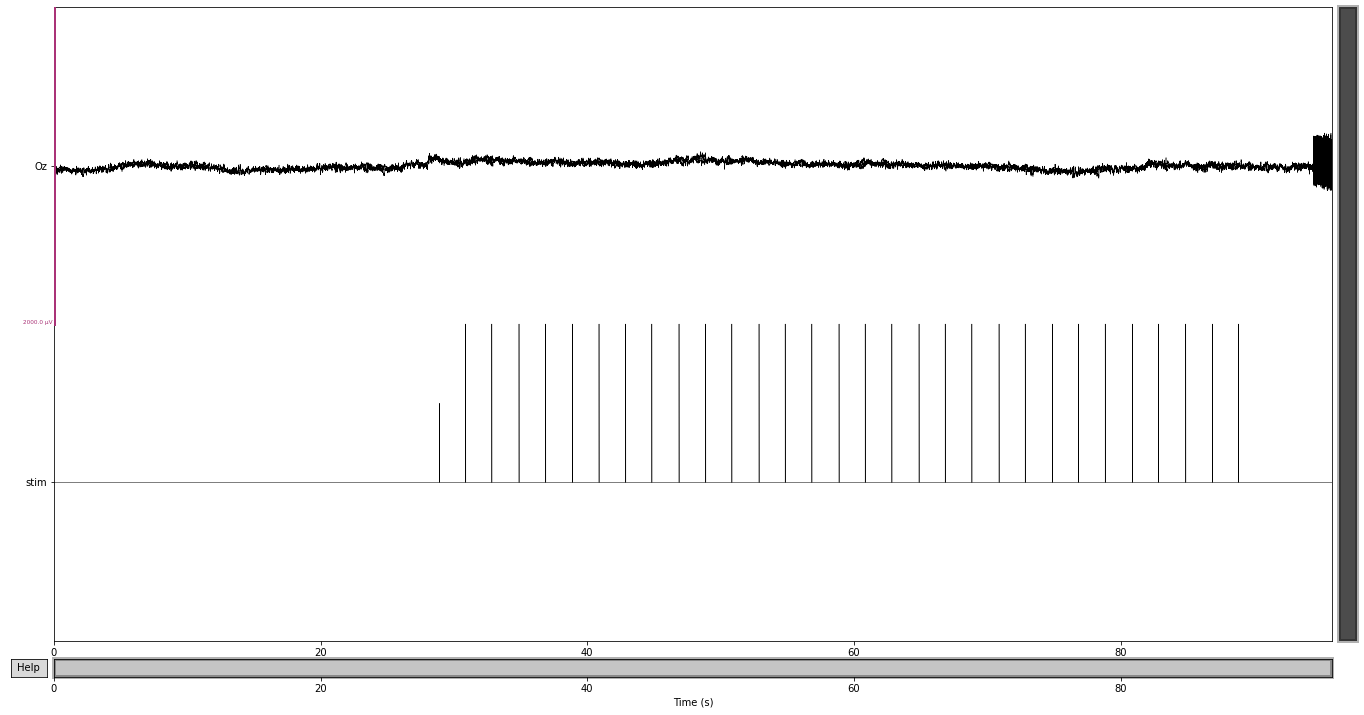

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
1 :


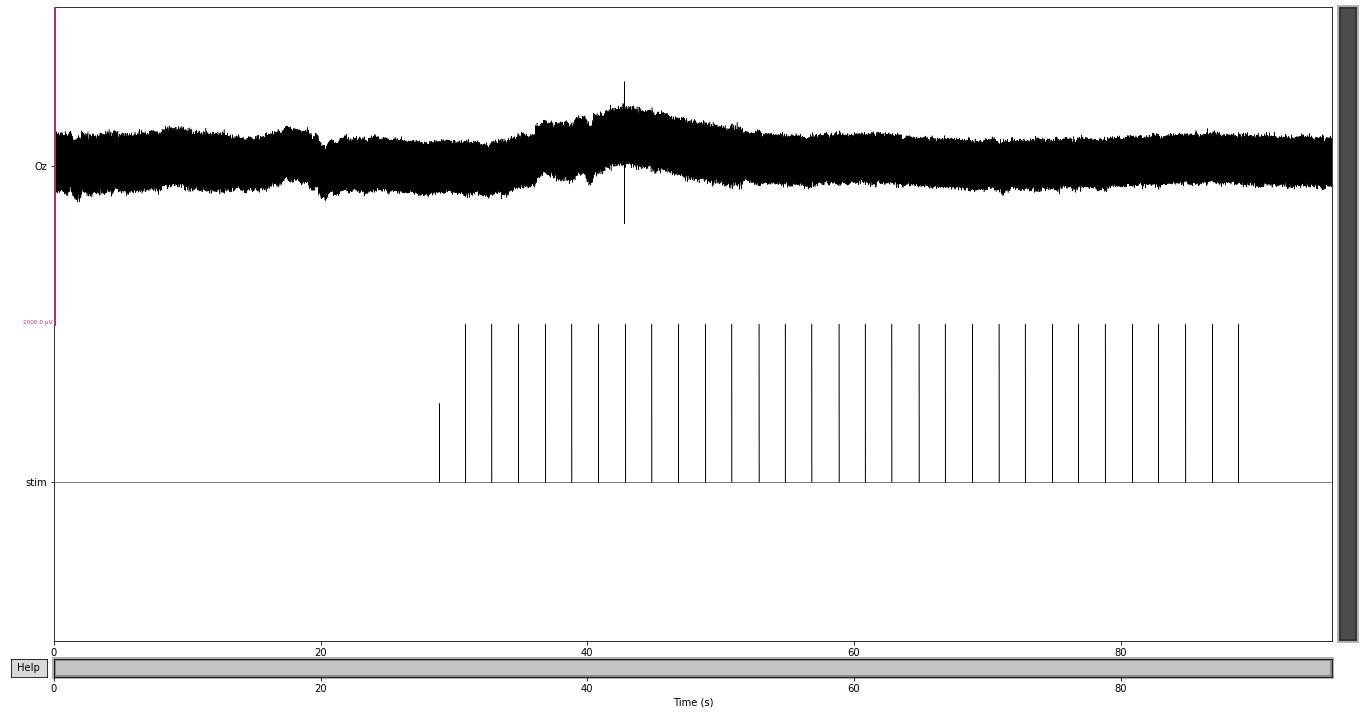

Creating RawArray with float64 data, n_channels=72, n_times=479400
    Range : 0 ... 479399 =      0.000 ...    95.880 secs
Ready.
2 :


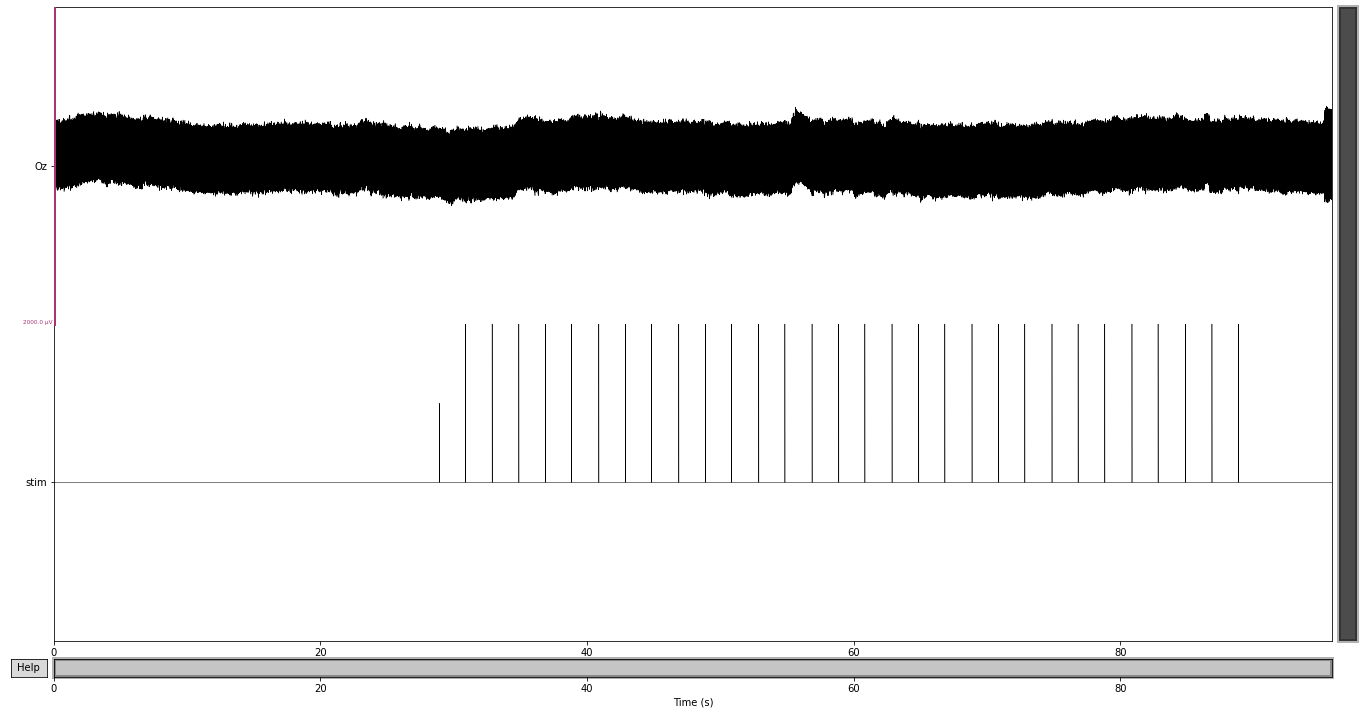

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
3 :


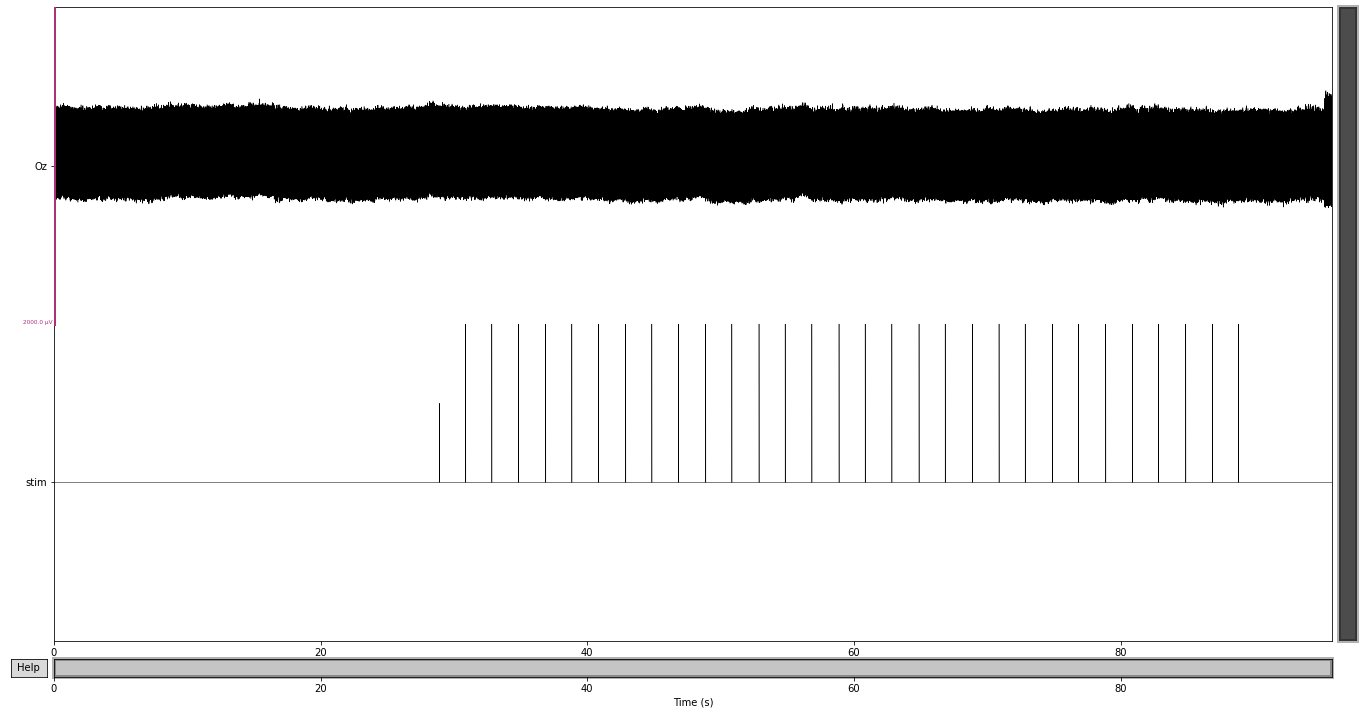

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
4 :


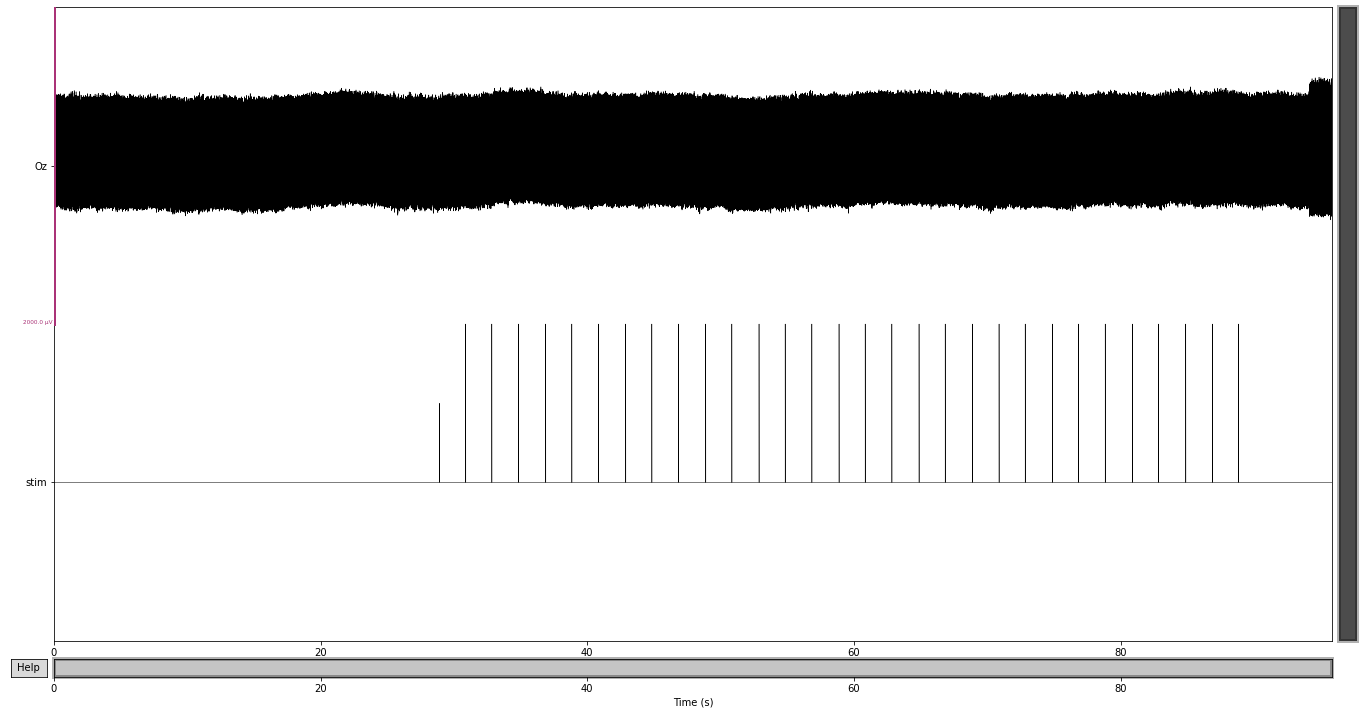

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
5 :


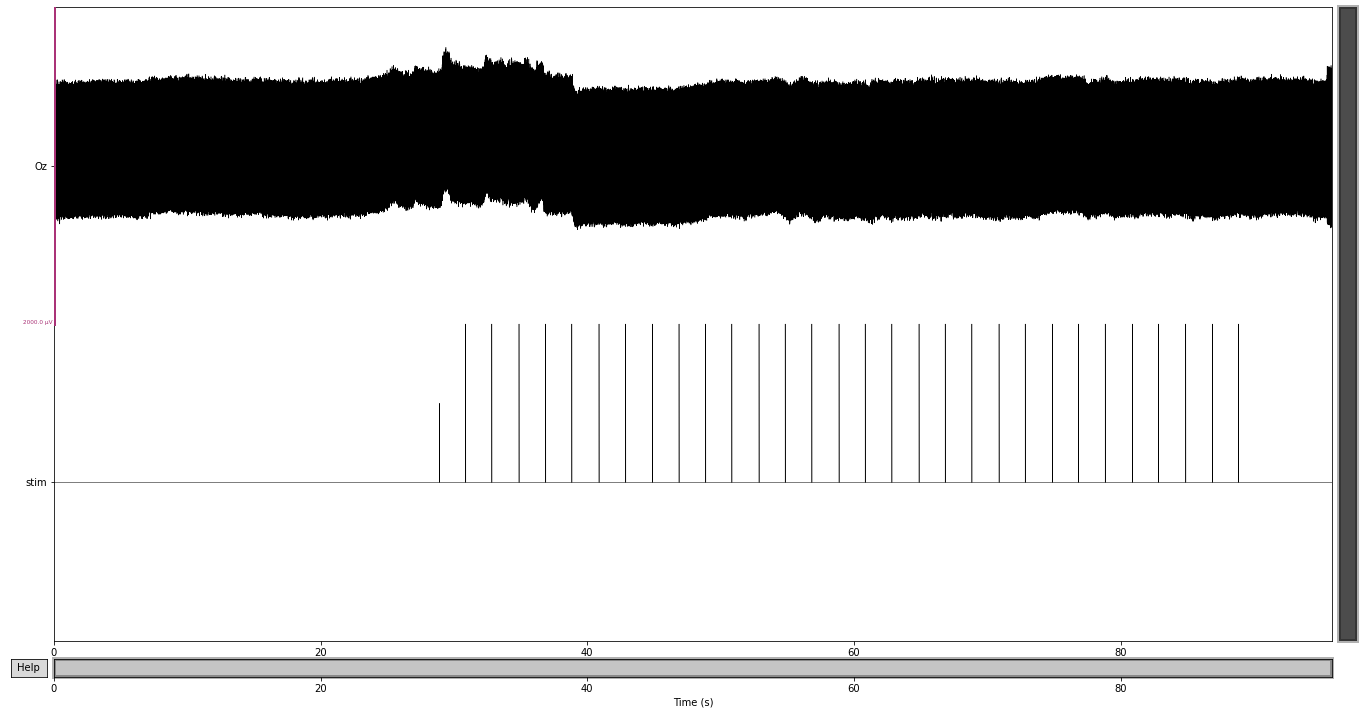

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
6 :


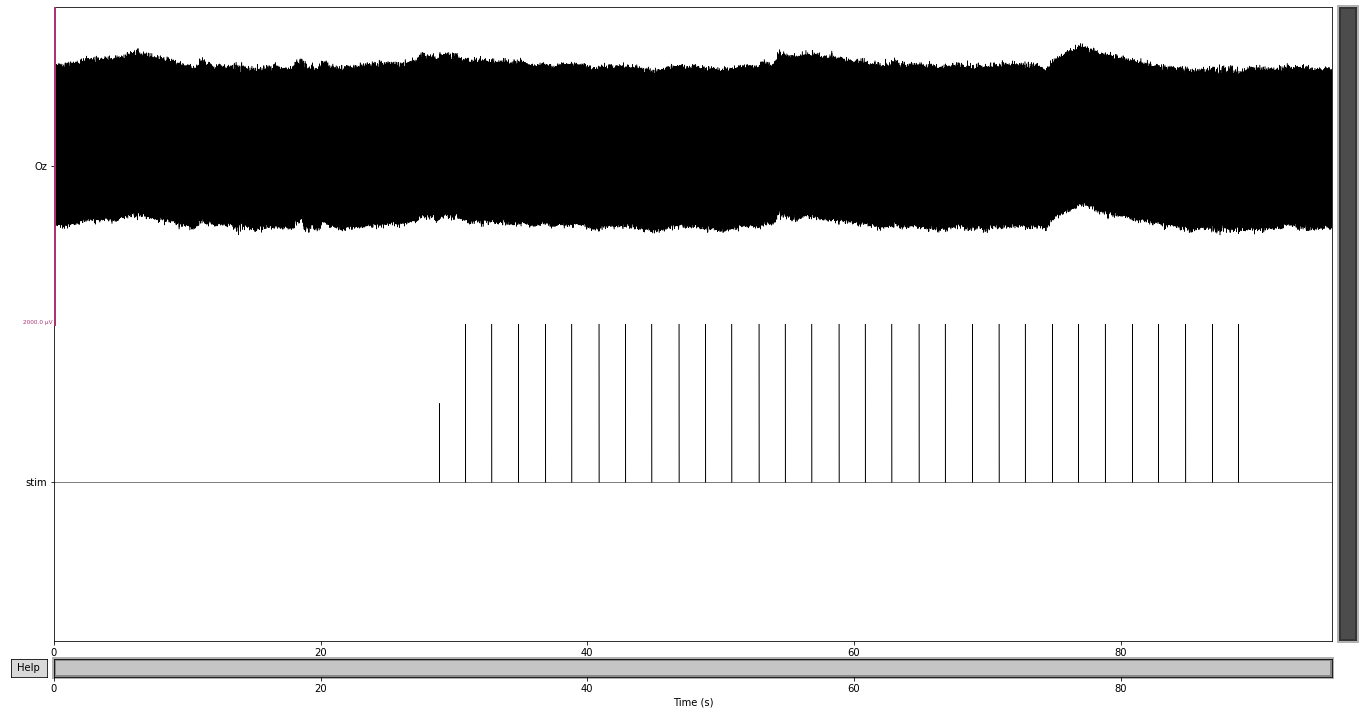

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
7 :


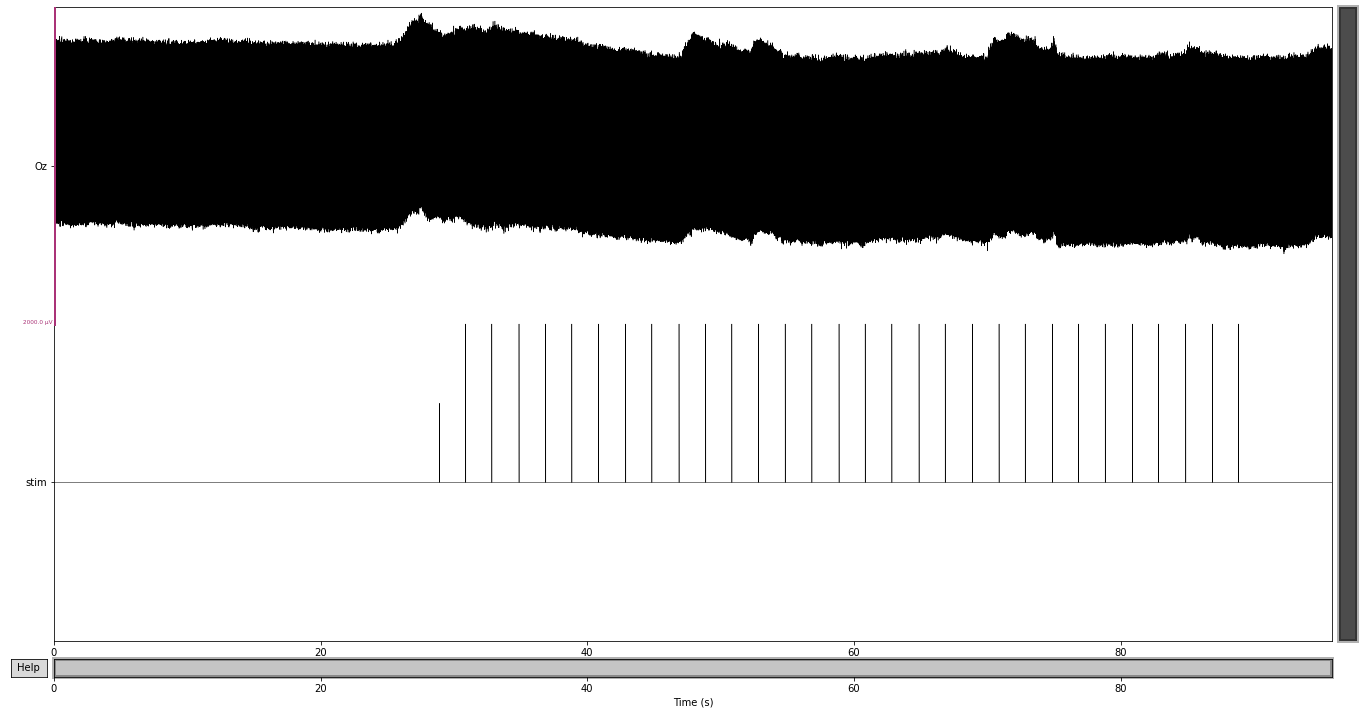

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
8 :


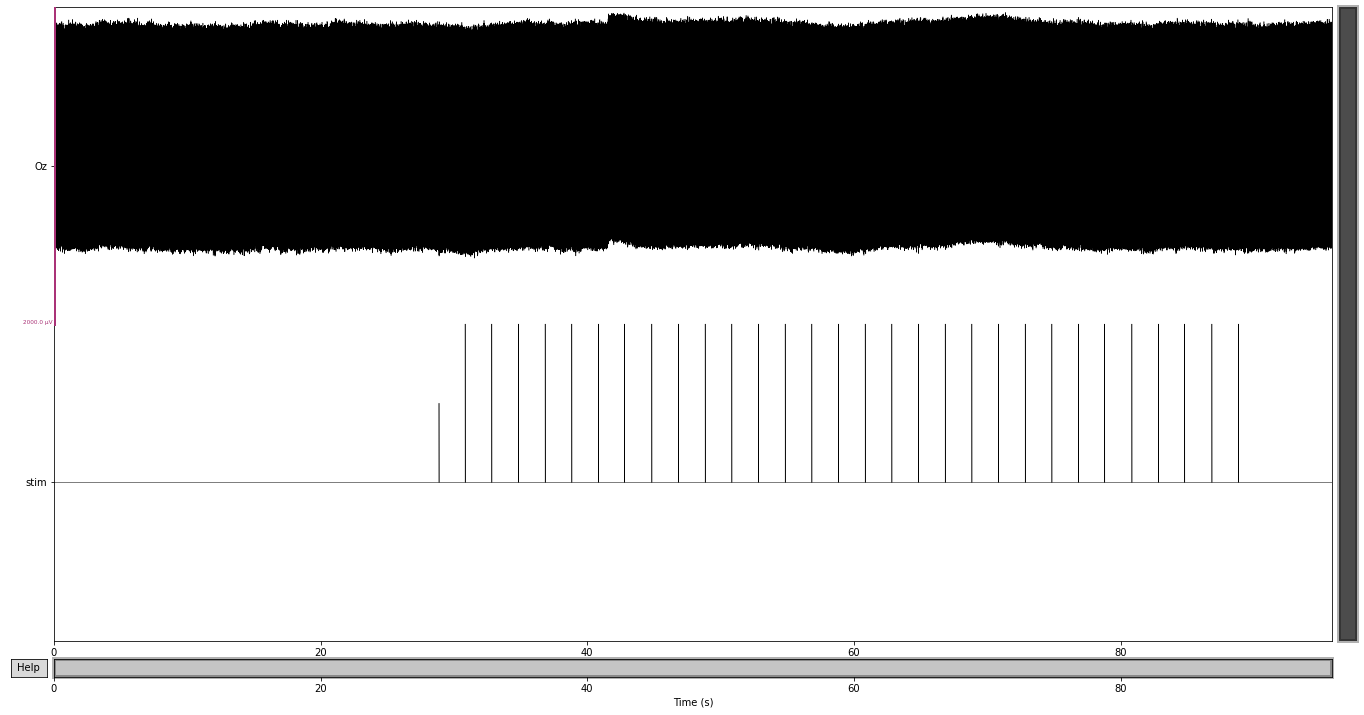

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
9 :


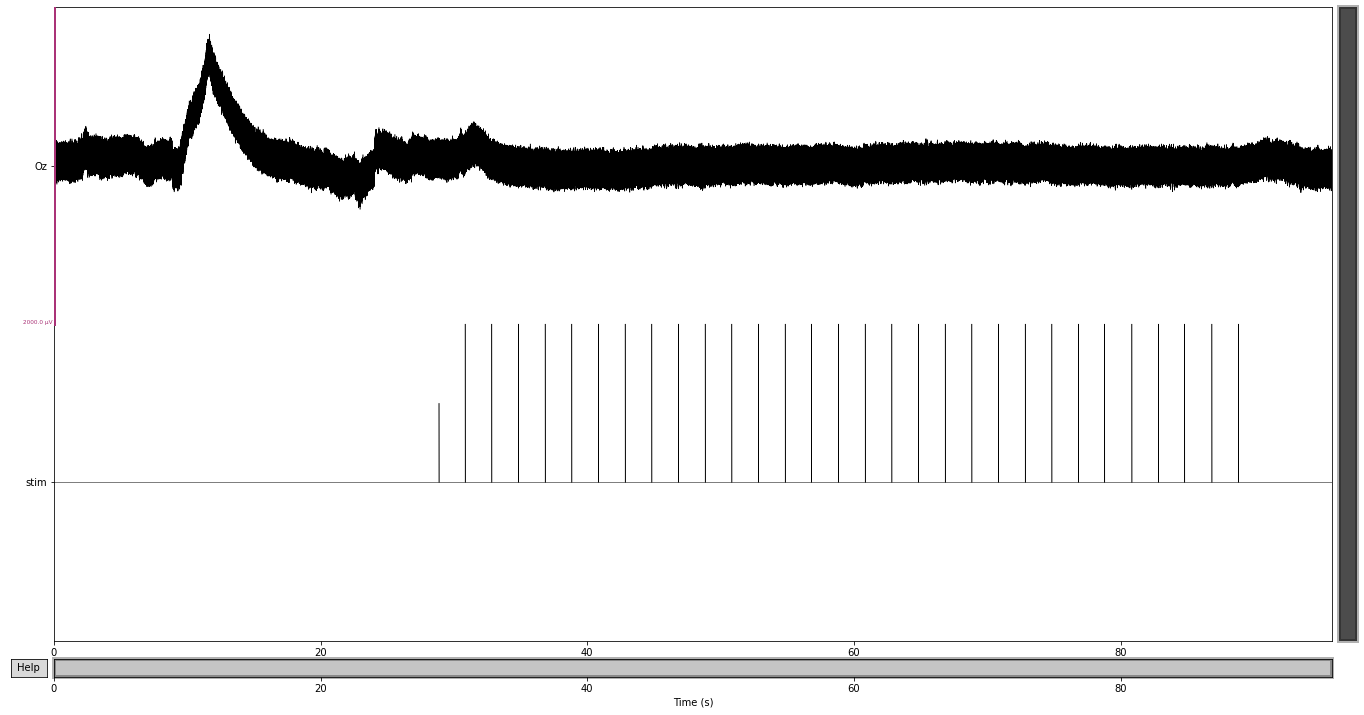

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
10 :


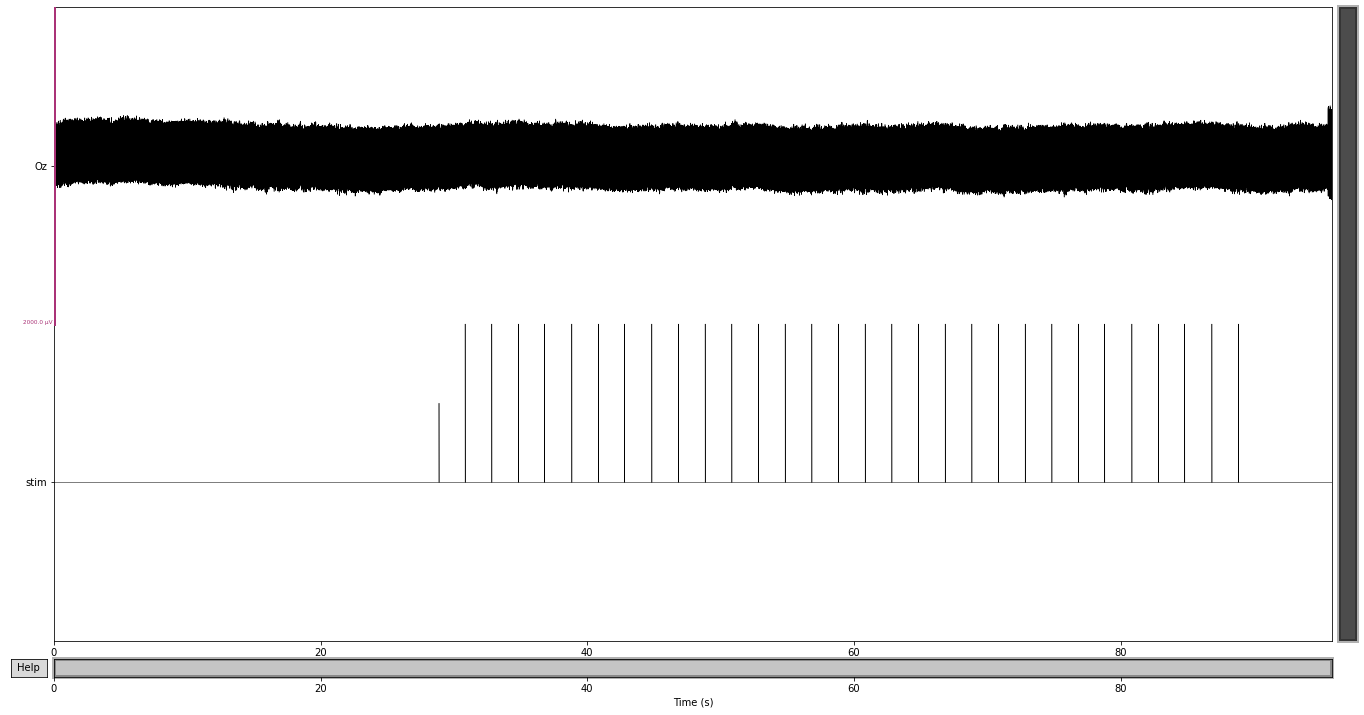

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
11 :


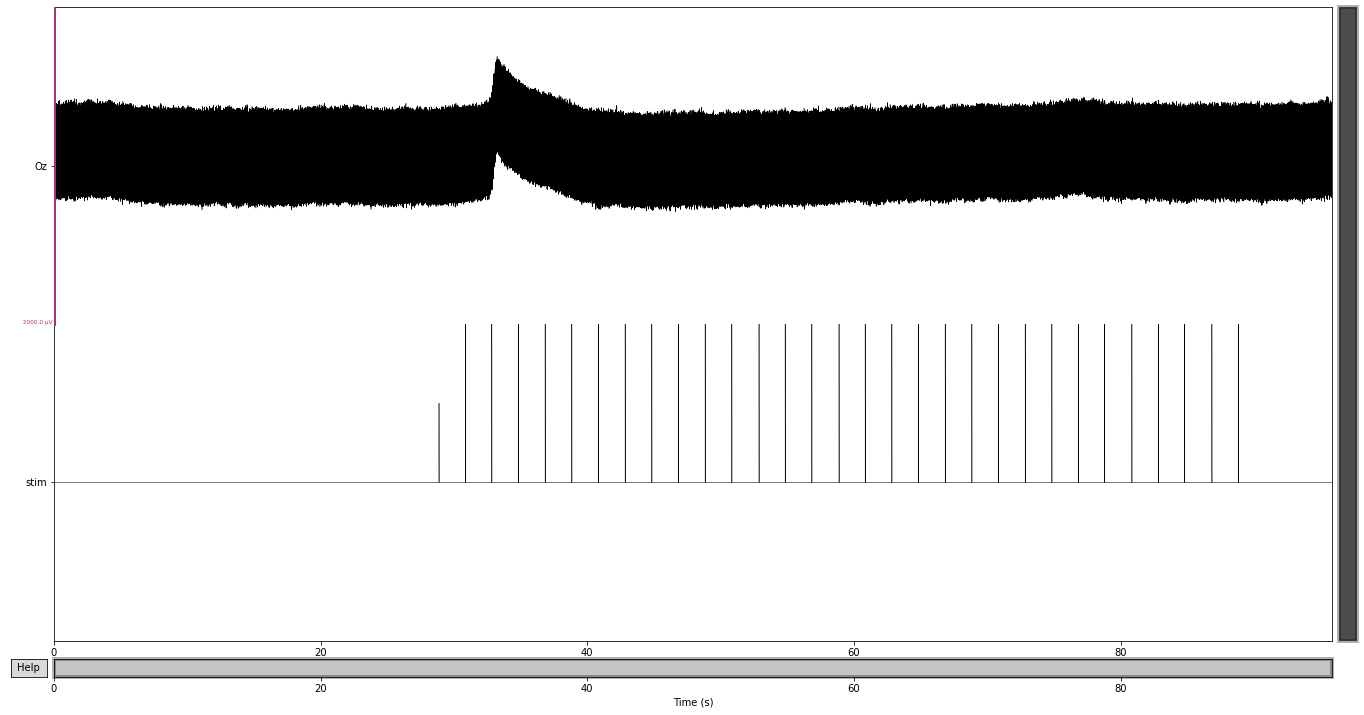

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
12 :


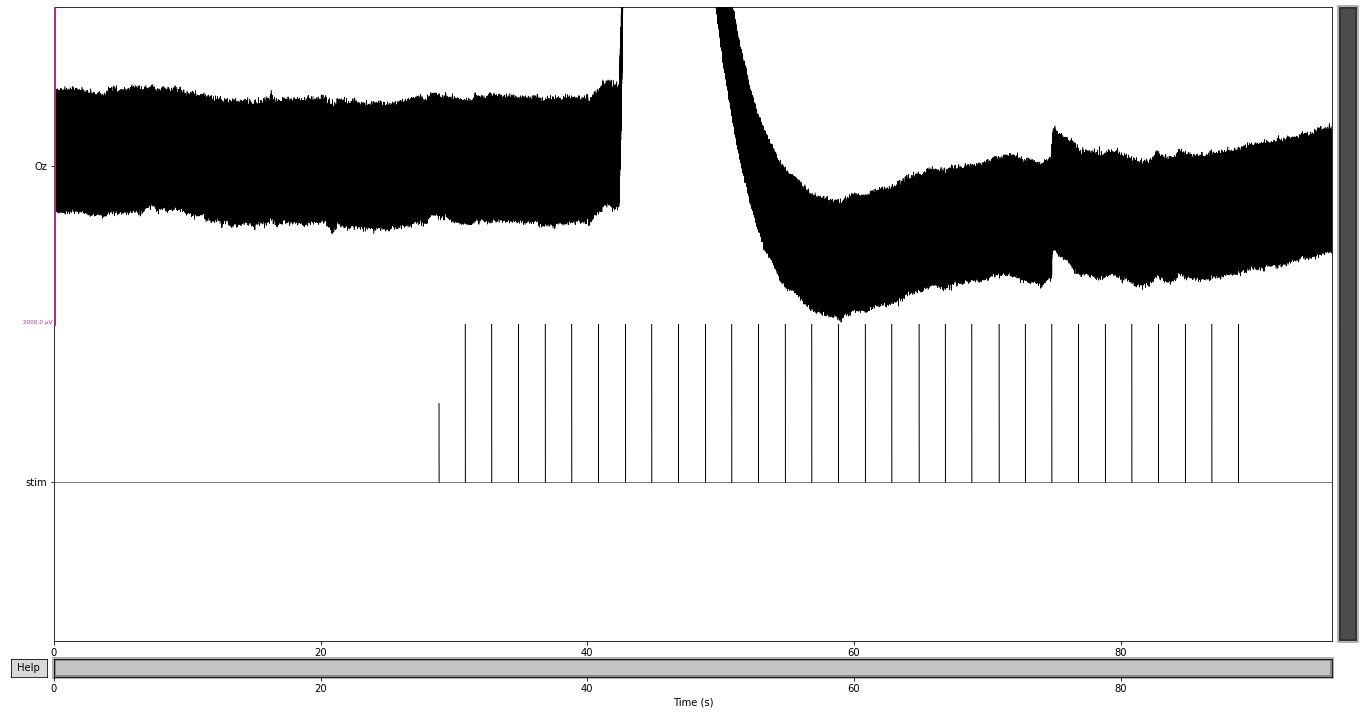

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
13 :


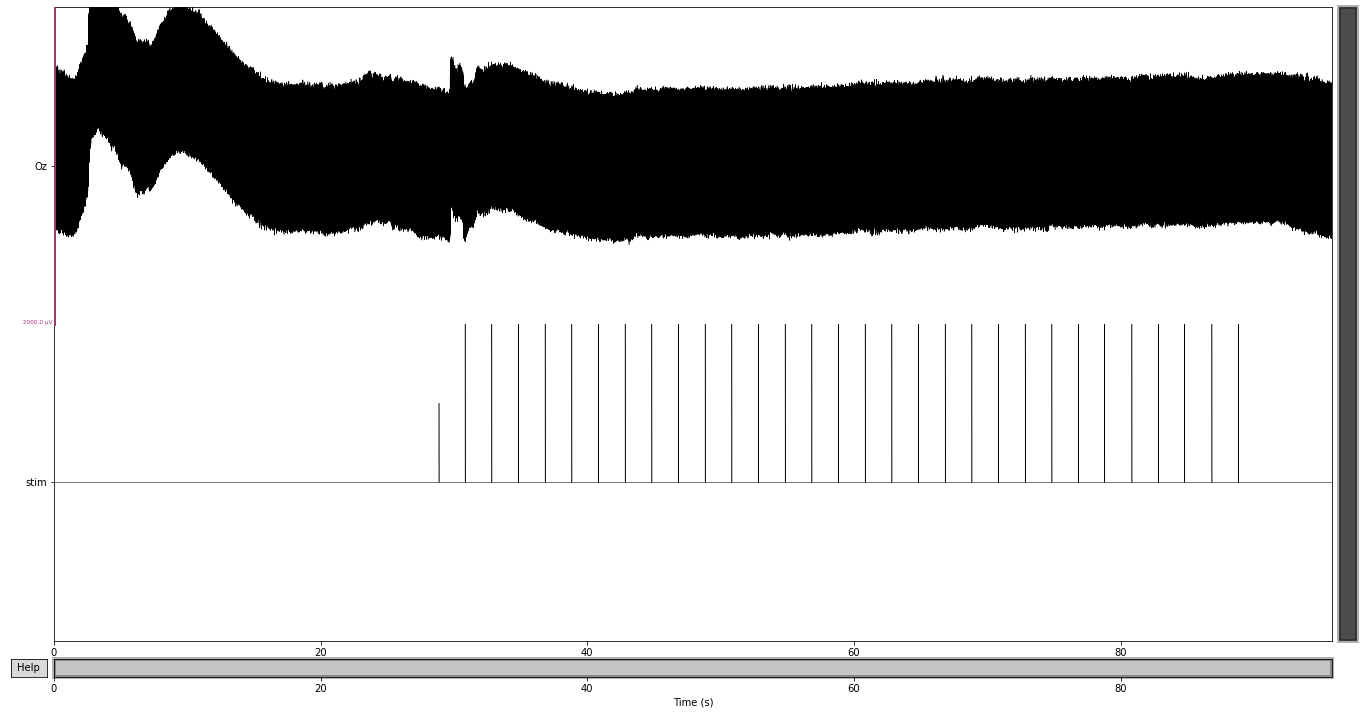

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
14 :


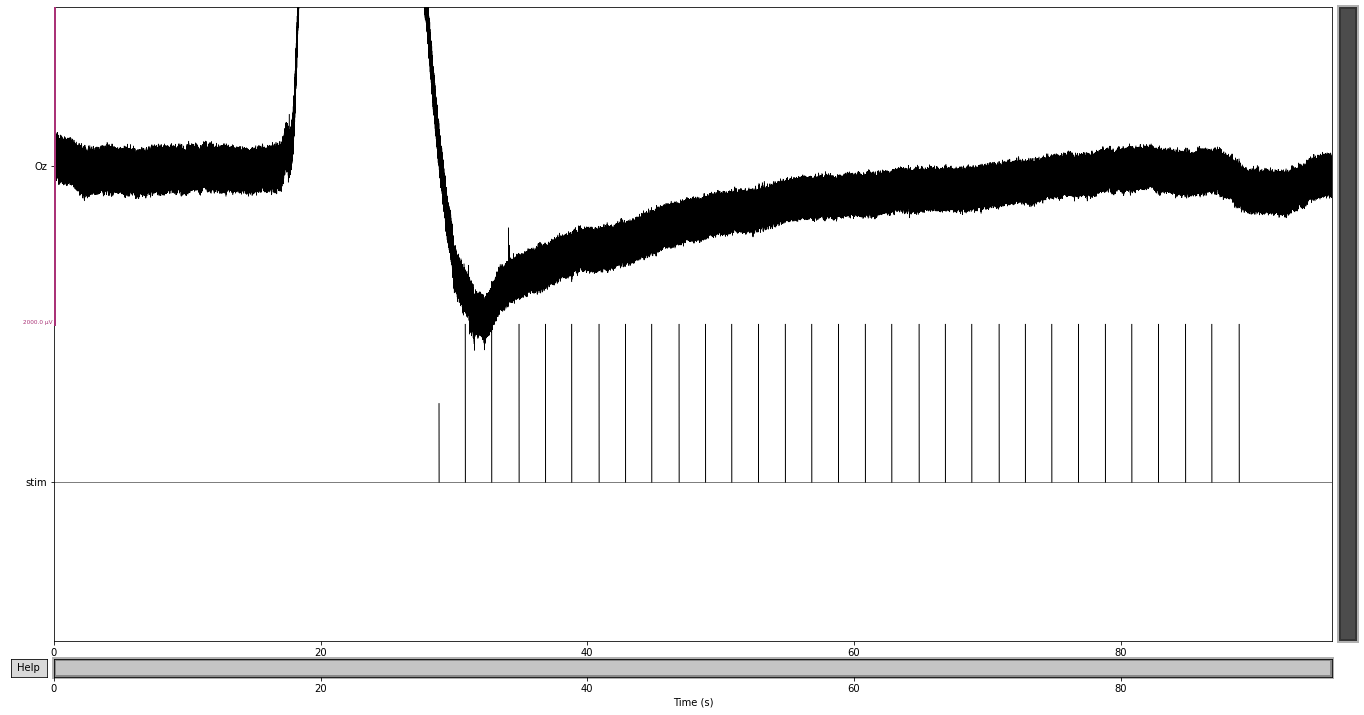

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
15 :


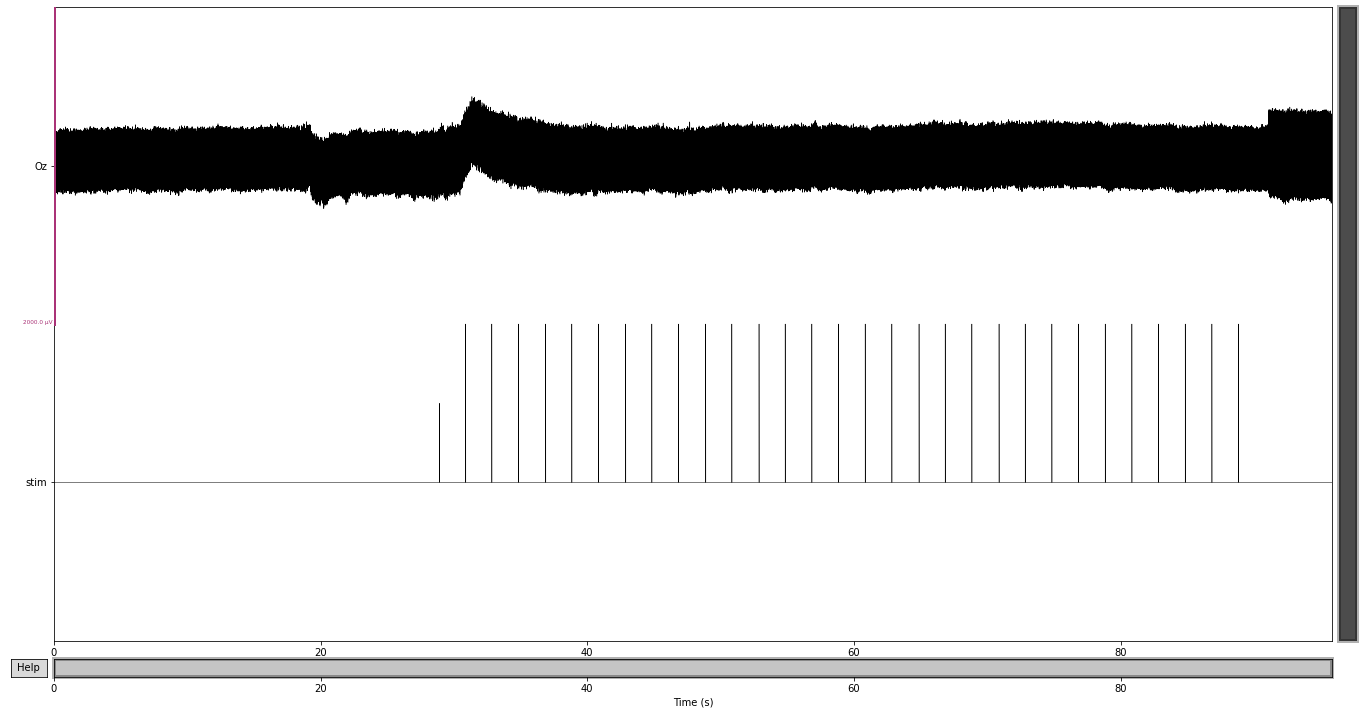

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
16 :


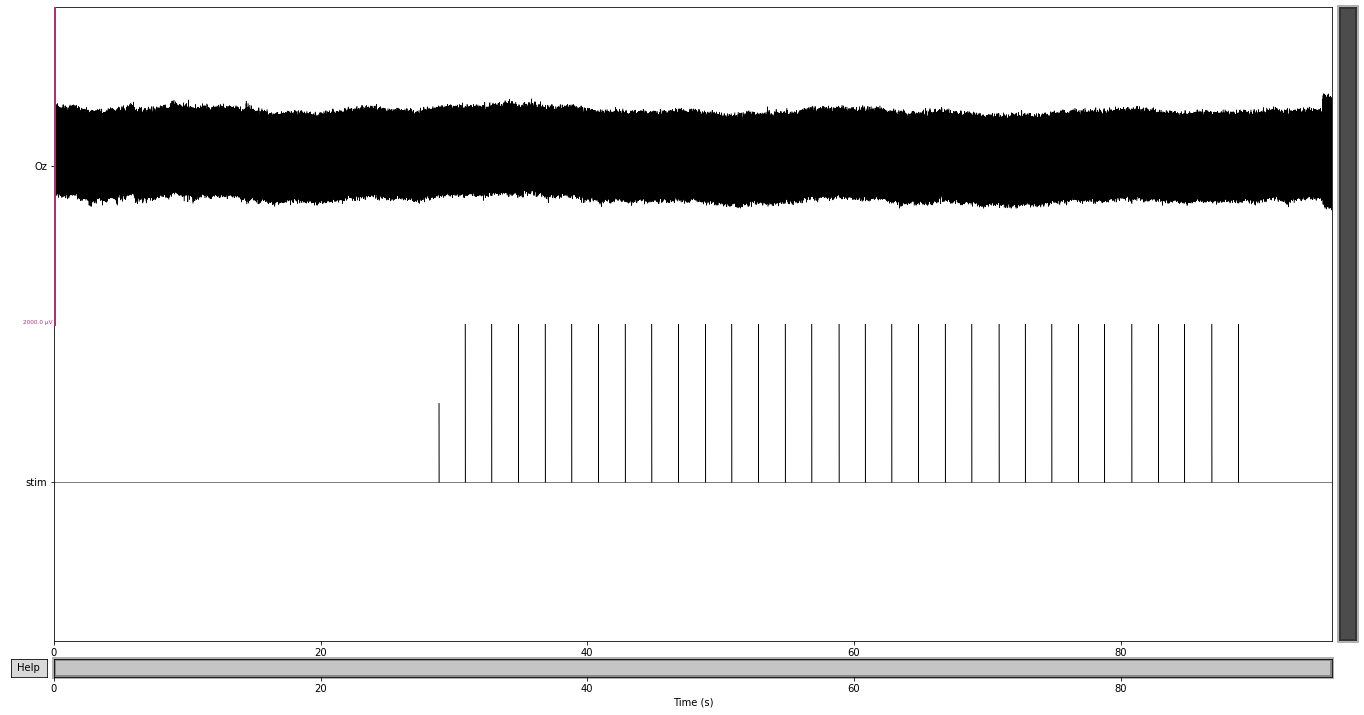

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
17 :


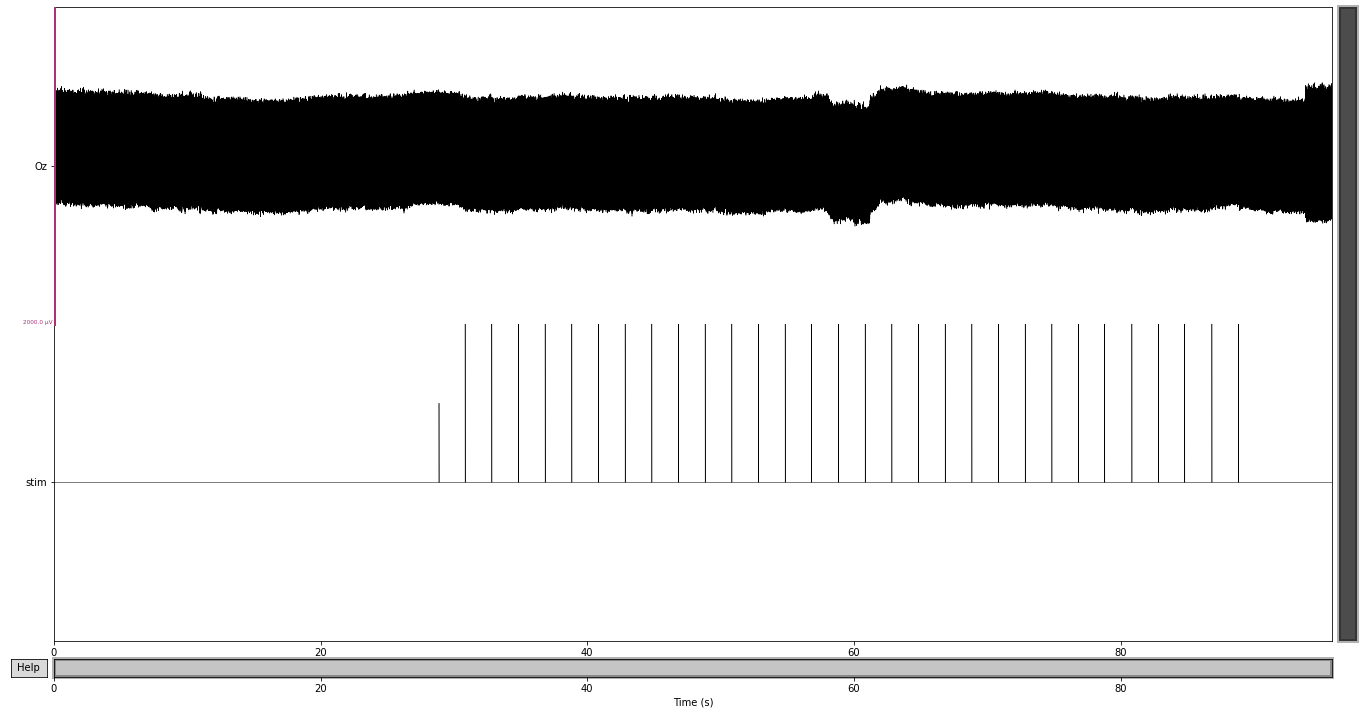

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
18 :


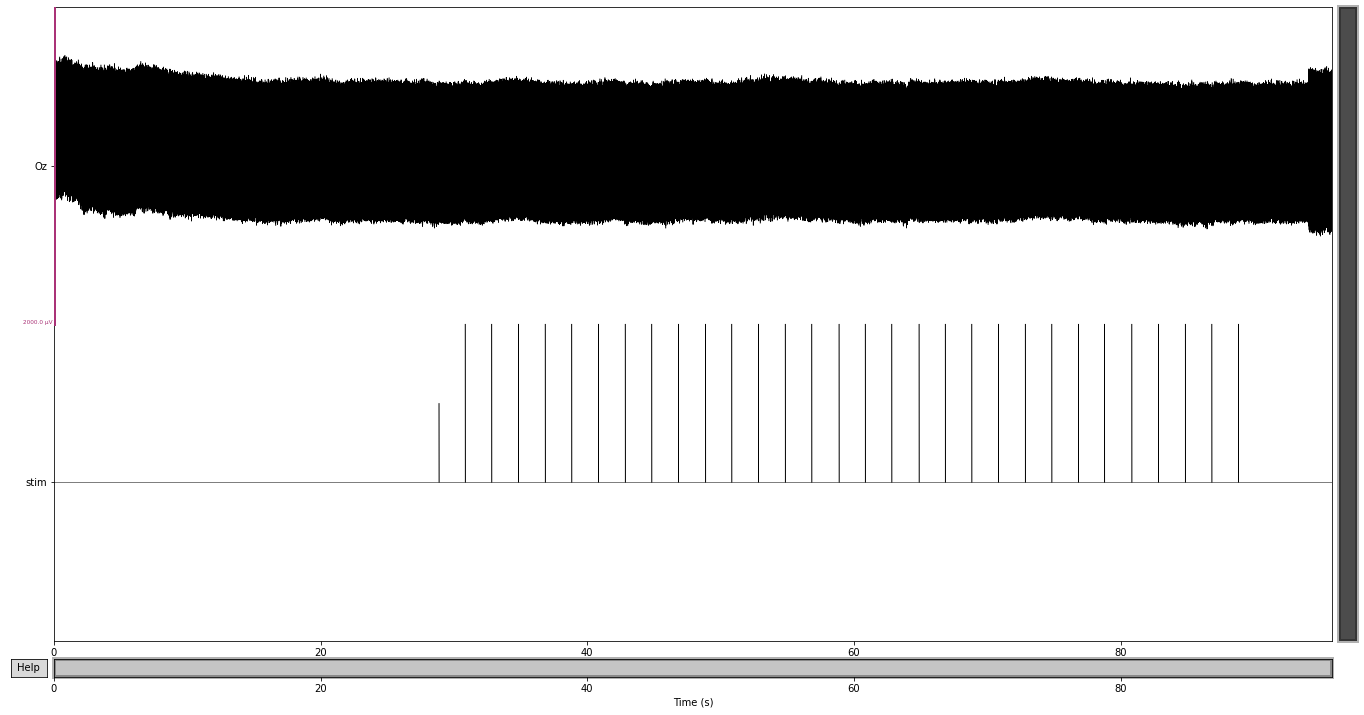

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
19 :


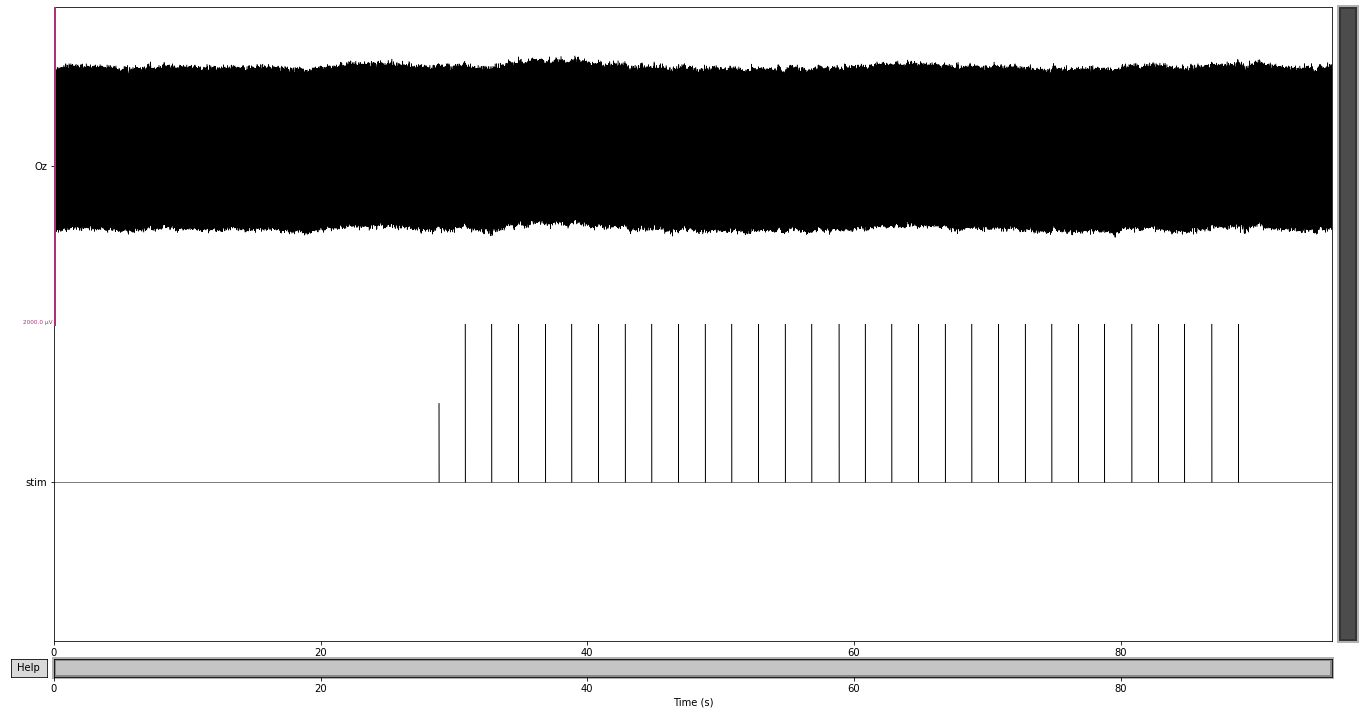

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
20 :


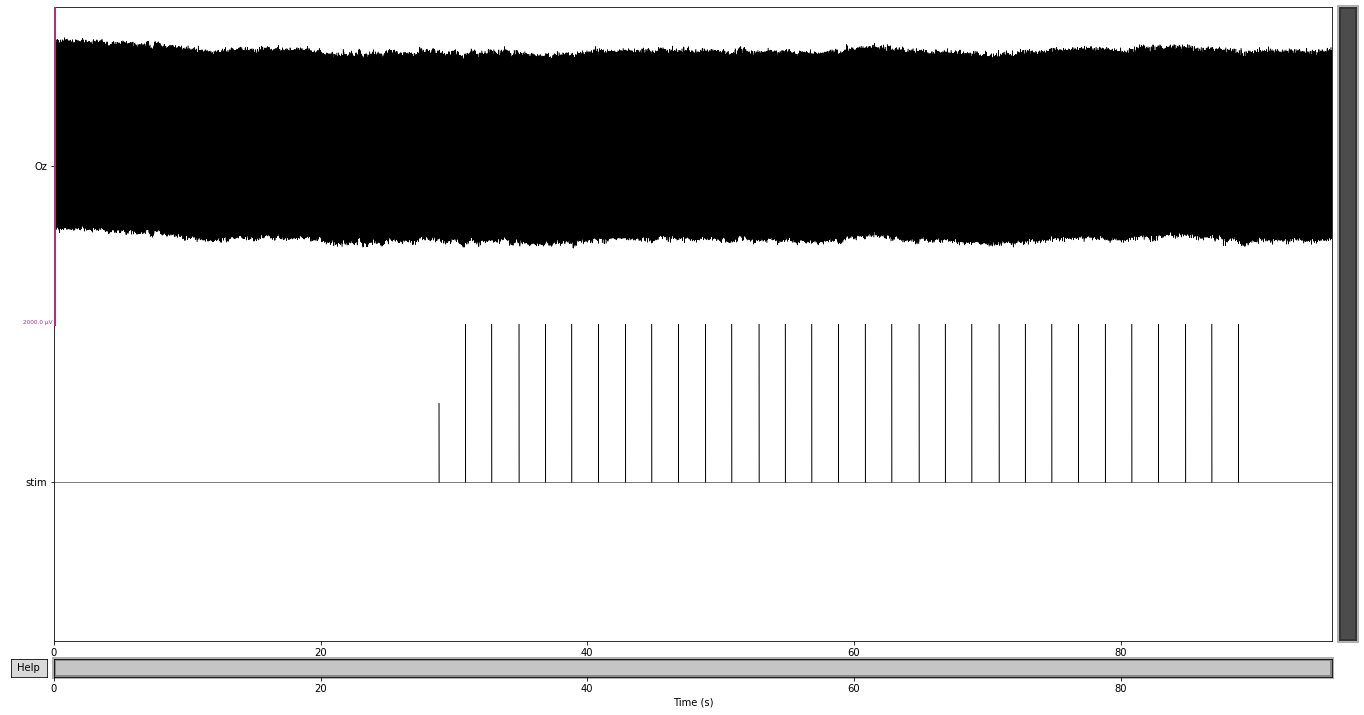

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
21 :


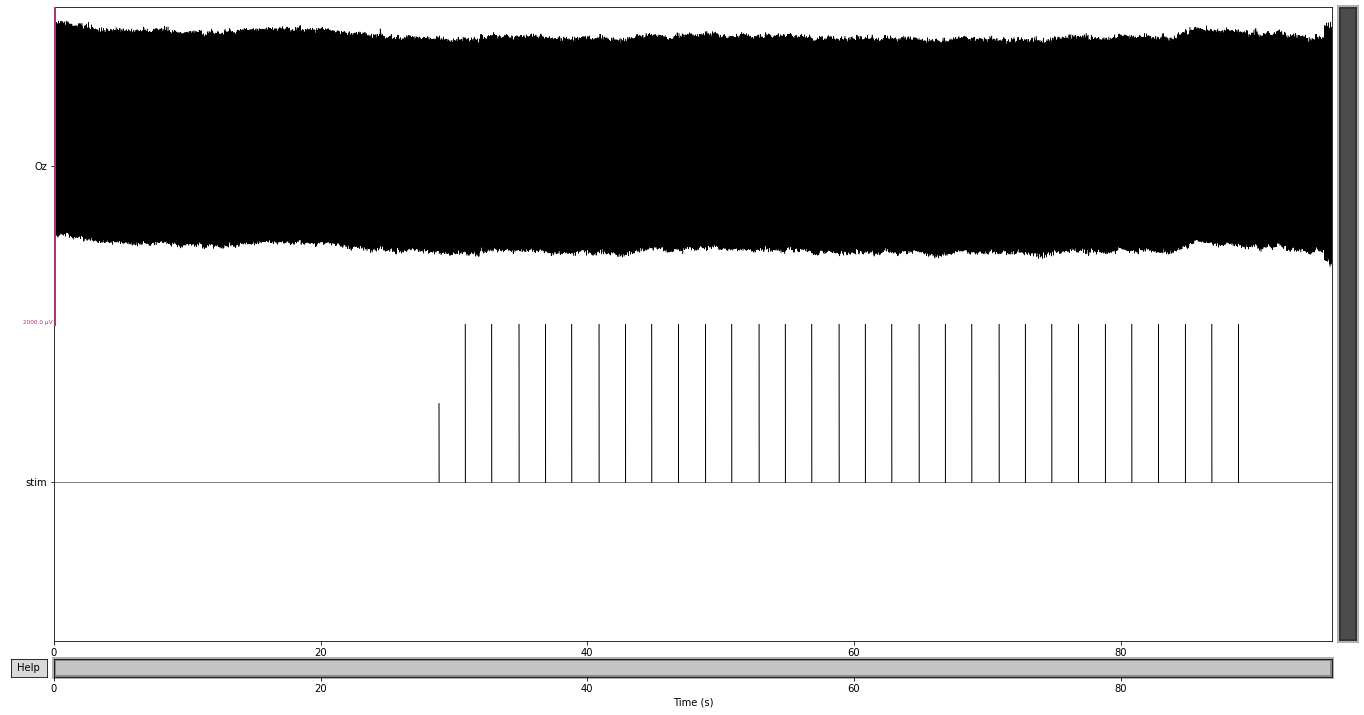

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
22 :


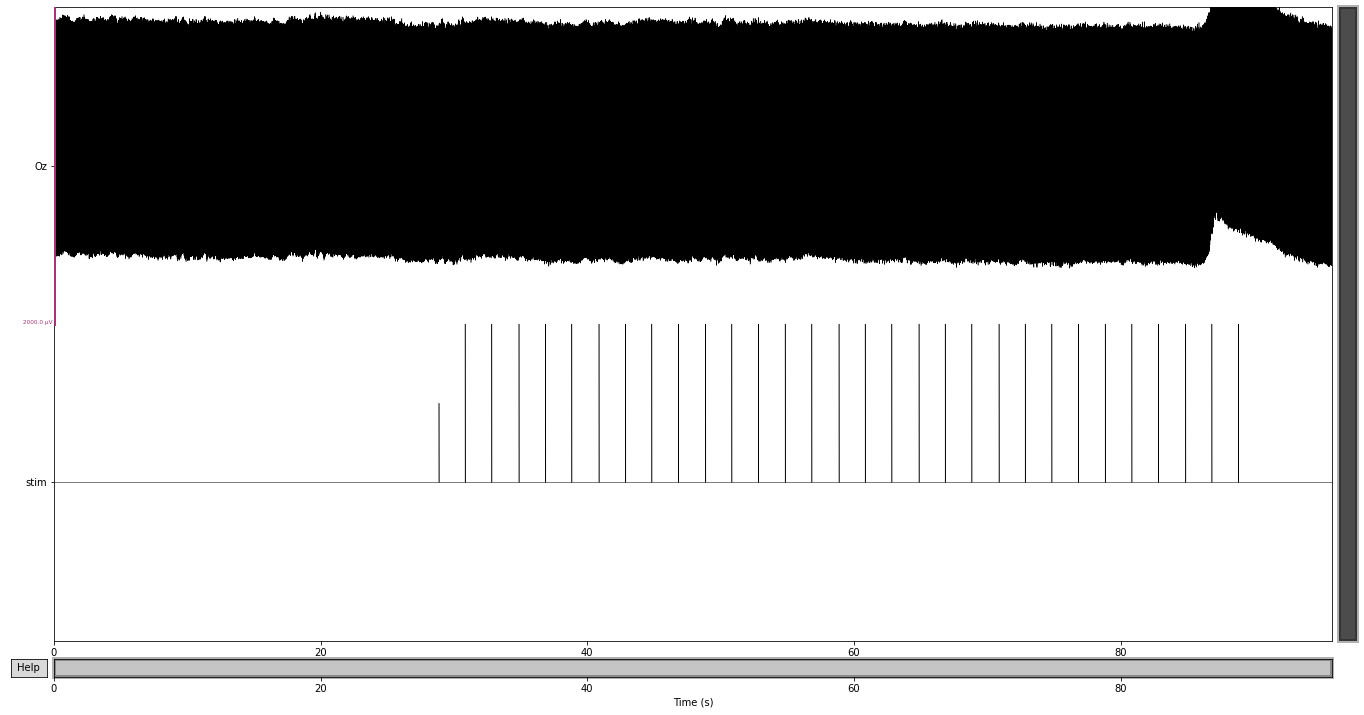

In [155]:
for i in range(23):
    _marker, _df_data=load_to_df(markers, npzs, i)
    _raw=df_to_mne(_marker, _df_data)
    print(i, ":")
    _raw.copy().pick_channels(['stim', 'Oz']).plot(start=0, duration=_raw.times[-1], n_channels=2, scalings=1e-3);

In [157]:
from pactools import simulate_pac, raw_to_mask, Comodulogram, MaskIterator

In [160]:
i=0
_marker, _df_data=load_to_df(markers, npzs, i)
_raw=df_to_mne(_marker, _df_data)
print(i, ":")
# _raw.copy().pick_channels(['stim', 'Oz']).plot(start=0, duration=_raw.times[-1], n_channels=2, scalings=1e-3);

Creating RawArray with float64 data, n_channels=72, n_times=479200
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
0 :


In [161]:
n_events = 100
mu = 1.  # mean onset of PAC in seconds
sigma = 0.25  # standard deviation of onset of PAC in seconds
trial_len = 2.  # len of the simulated trial in seconds
first_samp = 5  # seconds before the first sample and after the last

fs = 200.  # Hz
high_fq = 50.0  # Hz
low_fq = 3.0  # Hz
low_fq_width = 2.0  # Hz

n_points = int(trial_len * fs)
noise_level = 0.4


def gaussian1d(array, mu, sigma):
    return np.exp(-0.5 * ((array - mu) / sigma) ** 2)


Let's plot the signal and its power spectral density to visualize the data.
As shown in the plots below, there is a peak for the driver frequency at
3 Hz and a peak for the carrier frequency at 50 Hz but phase-amplitude
coupling cannot be seen in the evoked plot by eye because the signal is
averaged over different phases for each epoch.



Effective window size : 0.410 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


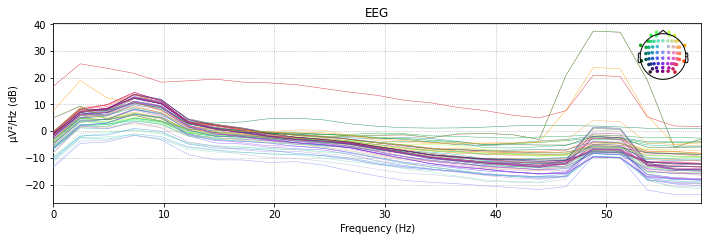

Not setting metadata
31 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


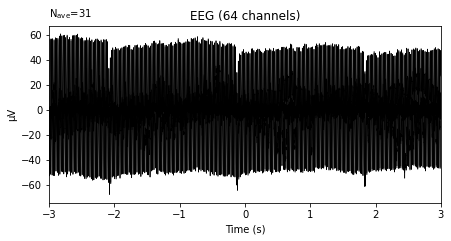

In [178]:
_raw.plot_psd(fmax=60)
epochs = mne.Epochs(_raw, events, tmin=-3, tmax=3)
# epochs = mne.make_fixed_length_epochs(_raw)
epochs.average().plot();

Let's save the raw object out for input/output demonstration purposes



In [179]:
root = mne.utils._TempDir()
raw.save(os.path.join(root, 'pac_example-raw.fif'))

Writing /tmp/tmp_mne_tempdir_2vppj1i2/pac_example-raw.fif
Closing /tmp/tmp_mne_tempdir_2vppj1i2/pac_example-raw.fif
[done]


Here we define how to build the epochs: which channels will be selected, and
on which time window around each event.



In [180]:
raw = mne.io.Raw(os.path.join(root, 'pac_example-raw.fif'))
events = mne.find_events(raw)

# select the time interval around the events
tmin, tmax = mu - 3 * sigma, mu + 3 * sigma
# select the channels (phase_channel, amplitude_channel)
ixs = (0, 0)

Opening raw data file /tmp/tmp_mne_tempdir_2vppj1i2/pac_example-raw.fif...
    Range : 0 ... 479199 =      0.000 ...    95.840 secs
Ready.
31 events found
Event IDs: [1 2]


Then, we create the inputs with the function raw_to_mask, which creates the
input arrays and the mask arrays. These arrays are then given to a
comodulogram instance with the `fit` method, and the `plot` method draws the
results.



In [181]:
# create the input array for Comodulogram.fit

low_sig, high_sig, mask = raw_to_mask(raw, ixs=ixs, events=events, tmin=tmin,
                                      tmax=tmax)

The mask is an iterable which goes over the _unique_ events in the event
array (if it is 3D). PAC is estimated where the `mask` is `False`.
Alternatively, we could also compute the `MaskIterator` object directly.
This is useful if you want to compute PAC on other kinds of time series,
for example source time courses.



[........................................] 100% | 4.03 sec | comodulogram: DAR(10, 1) 


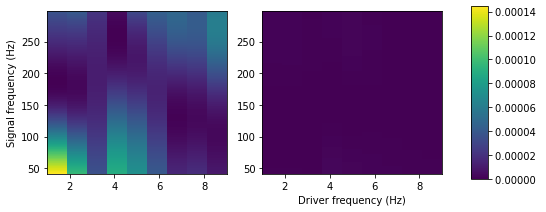

In [187]:
low_sig, high_sig = raw[ixs[0], :][0], raw[ixs[1], :][0]
mask = MaskIterator(events, tmin, tmax, raw.n_times, raw.info['sfreq'])

# create the instance of Comodulogram
estimator = Comodulogram(fs=raw.info['sfreq'],
                         low_fq_range=np.arange(1,10), low_fq_width=2.,
                         high_fq_range=np.arange(41,300), high_fq_width=0.5,
                         method='duprelatour', progress_bar=True)
# compute the comodulogram
estimator.fit(low_sig, high_sig, mask)
# plot the results
estimator.plot(tight_layout=False)
plt.show()